### Imports

In [68]:
# !LD_LIBRARY_PATH=$HOME/miniconda3/lib:$LD_LIBRARY_PATH
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [69]:
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import regularizers
import seaborn as sns
from sklearn import metrics
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

TensorFlow version: 2.14.1
Keras version: 2.14.0


### Visualizing the data

In [133]:

def visualize_confusion_matrix_for_models(X_test, Y_test, *models) -> None:
    """
    Visualizes the confusion matrices for multiple machine learning models.

    Parameters:
        X_test (array-like): Test data features.
        Y_test (array-like): True labels for the test data.
        *models (variable-length argument list): Machine learning models to evaluate.

    Returns:
        None. Displays confusion matrices using seaborn's heatmap.
    """
    num_models = len(models)
    plt.figure(figsize=(5 * num_models, 5))
    for i, model in enumerate(models, 1):
        plt.subplot(1, num_models, i)
        Y_pred = model.predict(X_test)
        Y_pred = (Y_pred > 0.5)
        matrix = metrics.confusion_matrix(Y_test, Y_pred)
        hm = sns.heatmap(matrix,
                         cmap='coolwarm',
                         linecolor='white',
                         linewidths=1,
                         annot=True,
                         fmt='d')
        plt.yticks(rotation=0)
        hm.set_ylim(0, len(matrix))
        plt.title(f'Confusion Matrix - Model {i}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(network, test_generator, samples_count: int) -> None:
    '''
    Plots the confusion matrix for the given network and test generator.
    Parameters:
    network: The network to evaluate.
    test_generator: The test generator to use.
    samples_count: The number of samples to use for the evaluation.
    
    Returns:
    None
    '''
    test_generator.reset()

    confusion_matrix = np.zeros((2, 2))
    used_instances = 0

    for images, labels in test_generator:
        if used_instances >= samples_count:
            break

        used_instances += len(labels)

        predictions = network.predict(images, verbose=False)
        
        predicted_labels = (predictions > 0.5).astype(np.int32).reshape(labels.shape)
        confusion_matrix += tf.math.confusion_matrix(labels, predicted_labels, num_classes=2)

    cm = (confusion_matrix / used_instances).numpy()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.show()

    print(f"Accuracy: {np.trace(cm)}")

def plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history.history['acc']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



def plot_loss_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation loss comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation loss values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = np.arange(1, len(histories[0].history['loss']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')

    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def print_val_accuracies(*histories) -> None:
    for i, history in enumerate(histories):
        val_accuracy = history.history['val_acc']
        argmax = np.argmax(val_accuracy)
        print(f'Max accuracy for model {i+1} is: {val_accuracy[argmax]}, achieved in the {argmax} epoch.')
  

In [138]:
import plotly.graph_objects as go
def plotly_plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    fig = go.Figure()

    for i, history in enumerate(histories):
        epochs = list(range(1, len(history.history['acc']) + 1))
        
        color = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        fig.add_trace(go.Scatter(x=epochs, y=acc, mode='markers', marker=dict(color=color), name=f'Training accuracy for {label}'))
        fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines', line=dict(color=color), name=f'Validation accuracy for {label}'))

    fig.update_layout(title='Comparison of Training and Validation Accuracies',
                      xaxis_title='Epochs',
                      yaxis_title='Accuracy',
                      hovermode='closest')
    fig.show()


### Get data

In [71]:
kaggle_dir = "kaggle"
    
processed_dir = kaggle_dir + "/processed"

cats_and_dogs_small_dir = processed_dir + "/cats_and_dogs_small"

base_dir = cats_and_dogs_small_dir + "/"

train_dir: str = base_dir + "train/"

train_cats_dir: str = train_dir + "cats/"
train_dogs_dir: str = train_dir + "dogs/"

validation_dir: str = base_dir + "validation/"

validation_cats_dir: str = validation_dir + "cats/"
validation_dogs_dir: str = validation_dir + "dogs/"

test_dir: str = base_dir + "test/"

test_cats_dir: str = test_dir + "cats/"
test_dogs_dir: str = test_dir + "dogs/"

models_dir: str = "models/"

In [72]:
from pathlib import Path

def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def create_dirs():
    all_paths: list[str] = [kaggle_dir, processed_dir, cats_and_dogs_small_dir,
                            base_dir, train_dir, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir]
    
    for path in all_paths:
        create_dir_if_not_exists(path)

def copy_train_images(indices: np.ndarray, animal: str ='cat', dir_type: str ='train'):
    for index in indices:
        src: str = f"kaggle/original/train/{animal}.{index}.jpg"
        dst: str = f"kaggle/processed/cats_and_dogs_small/{dir_type}/{animal}s/{animal}.{index}.jpg"
        shutil.copyfile(src, dst)

def remove_images():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir, ignore_errors=True)

def copy_all_images(validation_size=500, test_size=1000, max_train_size=20000):
    remove_images()

    create_dirs()
    print("Dirs created")
    
    files: list[str] = os.listdir("kaggle/original/train")

    cats_count: int = sum(1 for file in files if file.startswith("cat"))
    dogs_count: int = sum(1 for file in files if file.startswith("dog"))

    train_size_cats: int = min(cats_count - validation_size - test_size, max_train_size)
    train_size_dogs: int = min(dogs_count - validation_size - test_size, max_train_size)

    indices_cats = np.random.permutation(cats_count)
    indices_dogs = np.random.permutation(dogs_count)

    indices_cats_train = indices_cats[:train_size_cats]
    indices_dogs_train = indices_dogs[:train_size_dogs]

    indices_cats_validation = indices_cats[train_size_cats:train_size_cats + validation_size]
    indices_dogs_validation = indices_dogs[train_size_dogs:train_size_dogs + validation_size]

    indices_cats_test = indices_cats[train_size_cats + validation_size:train_size_cats + validation_size + test_size]
    indices_dogs_test = indices_dogs[train_size_dogs + validation_size:train_size_dogs + validation_size + test_size]


    copy_train_images(indices_cats_train, 'cat', 'train')
    copy_train_images(indices_dogs_train, 'dog', 'train')
    print("Train images copied")

    copy_train_images(indices_cats_validation, 'cat', 'validation')
    copy_train_images(indices_dogs_validation, 'dog', 'validation')
    print("Validation images copied")

    copy_train_images(indices_cats_test, 'cat', 'test')
    copy_train_images(indices_dogs_test, 'dog', 'test')
    print("Test images copied")

    print("All images copied")

In [73]:
copy_all_images(max_train_size=4000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


# Model

## Number of epochs

In [74]:
epochs_count: int = 200

## Structure

In [75]:
img_rows, img_cols = 150, 150

model1_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model1_a.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 17, 17, 128)      

In [76]:
model2_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model2_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2_a.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_20 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_42 (Conv2D)          (None, 70, 70, 128)       73856     
                                                                 
 batch_normalization_21 (Ba  (None, 70, 70, 128)      

In [77]:
model3_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model3_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3_a.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_46 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 conv2d_47 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 72, 72, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 70, 70, 64)        36928     
                                                                 
 batch_normalization_24 (Ba  (None, 70, 70, 64)        256       
 tchNormalization)                                    

In [78]:
model4_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model4_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4_a.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_53 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_54 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_28 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 46, 46, 64)       

In [79]:
model5_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model5_a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5_a.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_62 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_63 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_34 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 46, 46, 64)       

## Data Augumentation

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training

In [81]:
# history1 = model1.fit_generator(
history1_a = model1_a.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs_count,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/200
100/100 [==============================] - 13s 114ms/step - loss: 0.6934 - acc: 0.5050 - val_loss: 0.6926 - val_acc: 0.5180
Epoch 2/200
100/100 [==============================] - 13s 131ms/step - loss: 0.6926 - acc: 0.5140 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 11s 108ms/step - loss: 0.6914 - acc: 0.5245 - val_loss: 0.6907 - val_acc: 0.5010
Epoch 4/200
100/100 [==============================] - 12s 123ms/step - loss: 0.6918 - acc: 0.5190 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 5/200
100/100 [==============================] - 12s 125ms/step - loss: 0.6894 - acc: 0.5375 - val_loss: 0.6893 - val_acc: 0.5110
Epoch 6/200
100/100 [==============================] - 11s 107ms/step - loss: 0.6850 - acc: 0.5605 - val_loss: 0.6699 - val_acc: 0.6170
Epoch 7/200
100/100 [==============================] - 13s 128ms/step - loss: 0.6756 - acc: 0.5770 - val_loss: 0.6655 - val_acc: 0.5890
Epoch 8/200
100/100 [===========================

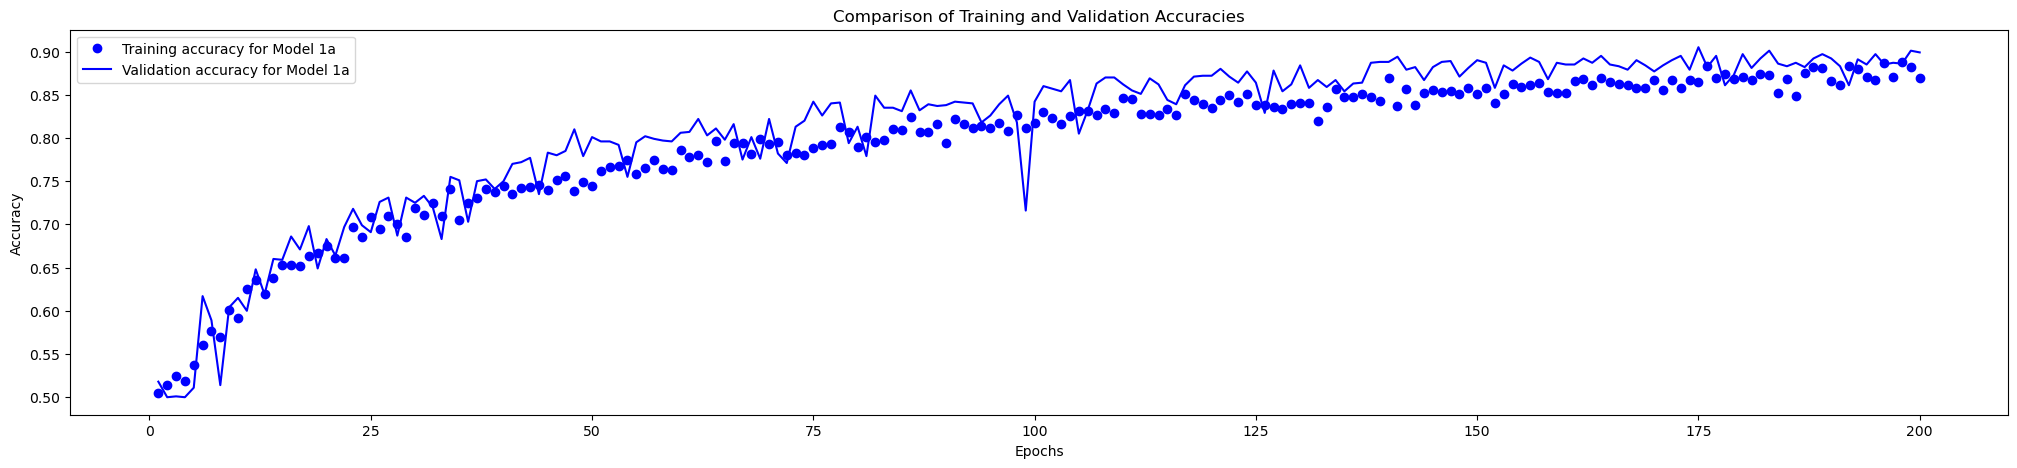

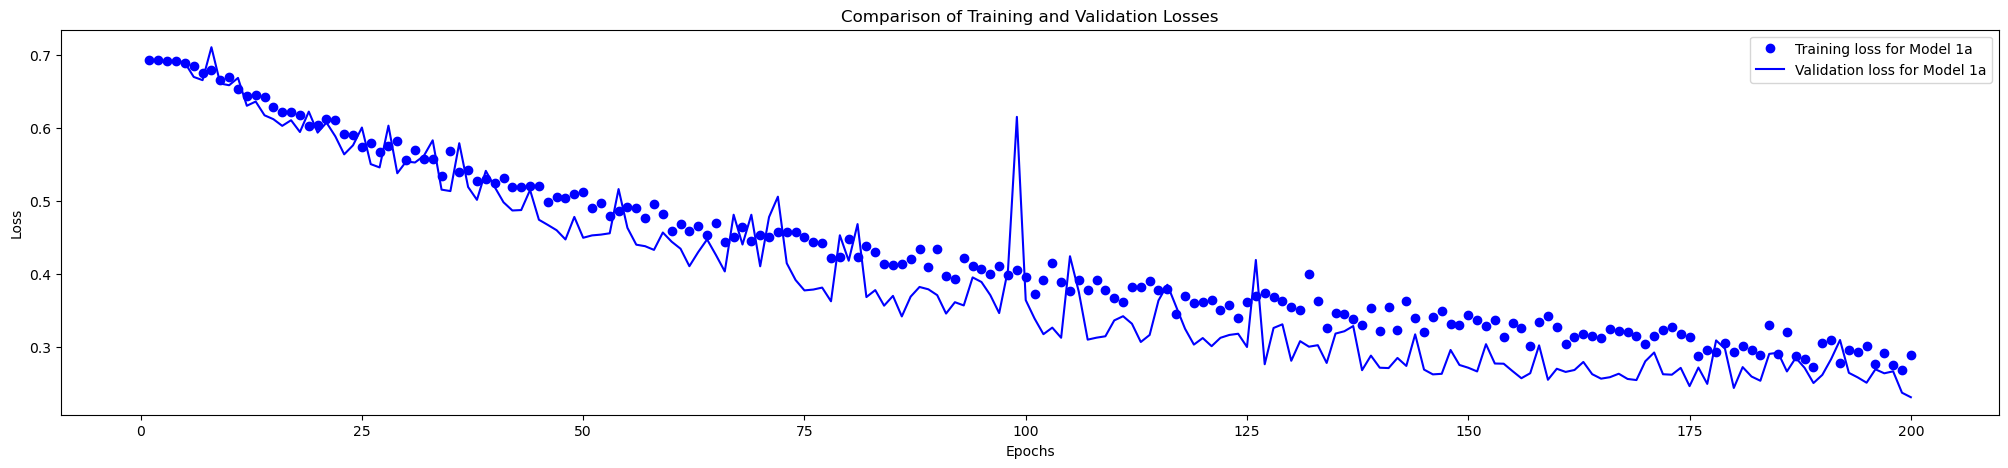

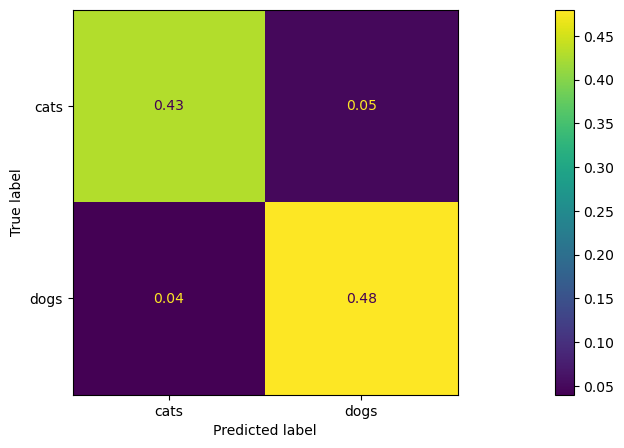

Accuracy: 0.9099999999999999


In [82]:
plot_accuracy_comparison(history1_a, labels=['Model 1a'])
plot_loss_comparison(history1_a, labels=['Model 1a'])
plot_confusion_matrix(model1_a, validation_generator, 100)

In [83]:
history2_a = model2_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/200
100/100 [==============================] - 15s 130ms/step - loss: 2.0382 - acc: 0.5630 - val_loss: 1.4416 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 13s 127ms/step - loss: 1.9857 - acc: 0.5725 - val_loss: 0.9292 - val_acc: 0.5020
Epoch 3/200
100/100 [==============================] - 11s 113ms/step - loss: 1.6534 - acc: 0.5740 - val_loss: 2.1839 - val_acc: 0.5060
Epoch 4/200
100/100 [==============================] - 13s 126ms/step - loss: 1.3911 - acc: 0.5920 - val_loss: 0.9974 - val_acc: 0.5790
Epoch 5/200
100/100 [==============================] - 11s 106ms/step - loss: 1.3037 - acc: 0.5945 - val_loss: 1.8704 - val_acc: 0.5500
Epoch 6/200
100/100 [==============================] - 13s 125ms/step - loss: 1.1068 - acc: 0.6115 - val_loss: 1.2647 - val_acc: 0.5840
Epoch 7/200
100/100 [==============================] - 13s 125ms/step - loss: 1.1727 - acc: 0.6005 - val_loss: 1.0522 - val_acc: 0.6120
Epoch 8/200
100/100 [===========================

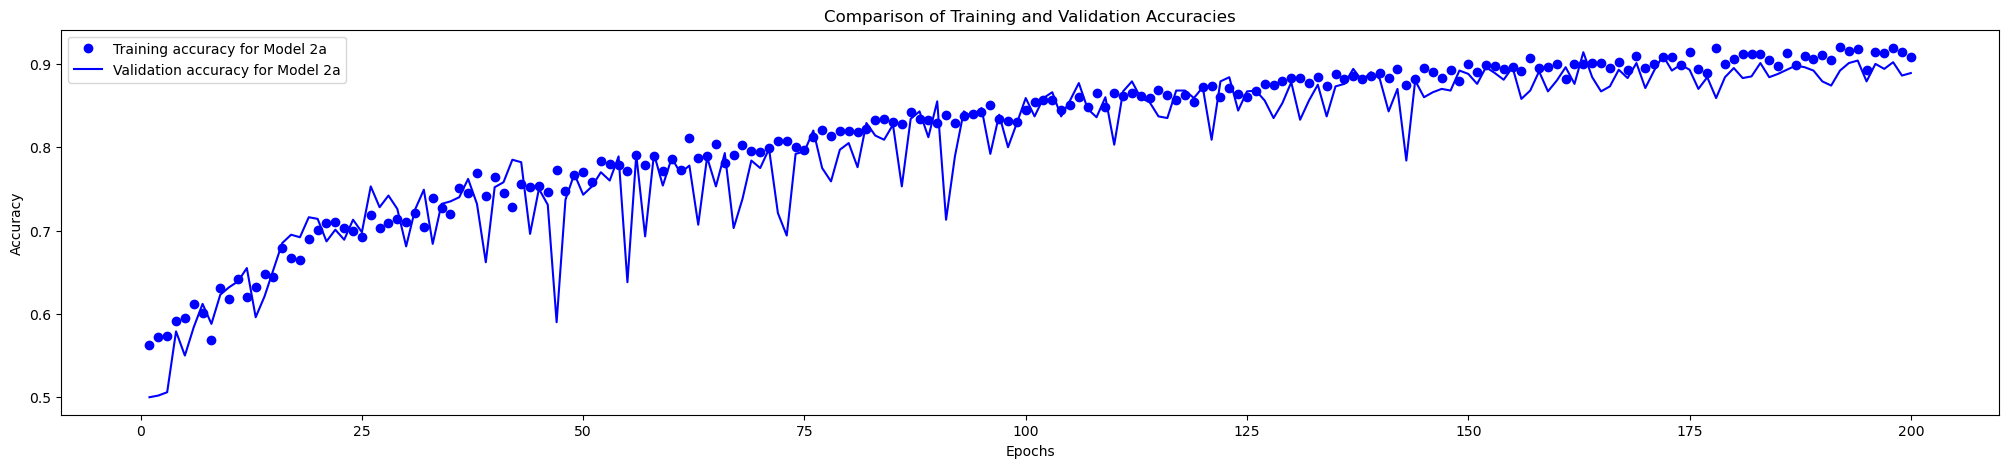

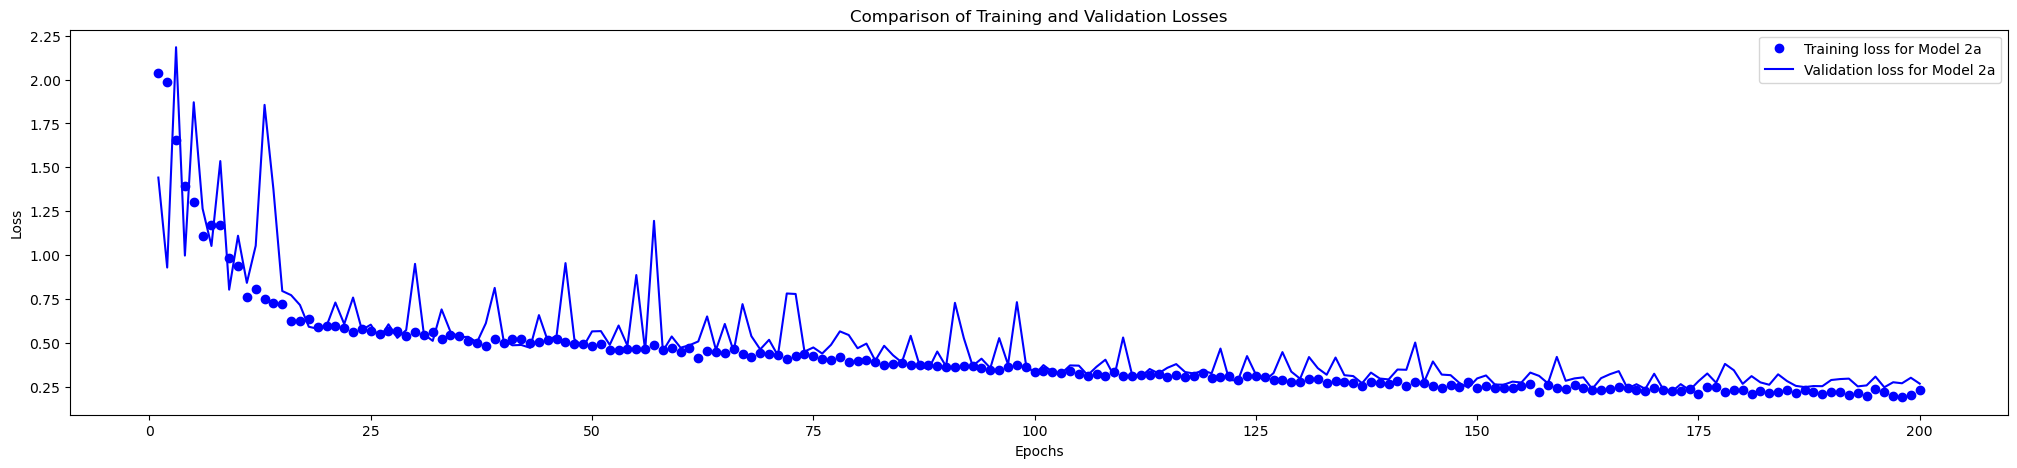

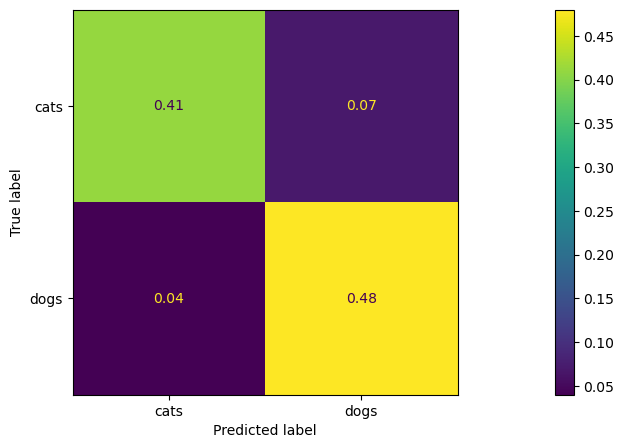

Accuracy: 0.8899999999999999


In [84]:
plot_accuracy_comparison(history2_a, labels=['Model 2a'])
plot_loss_comparison(history2_a, labels=['Model 2a'])
plot_confusion_matrix(model2_a, validation_generator, 100)

In [85]:
history3_a = model3_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200


2024-04-14 03:54:52.288294: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 17s 133ms/step - loss: 0.9006 - acc: 0.5535 - val_loss: 0.7427 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 15s 146ms/step - loss: 0.8093 - acc: 0.5715 - val_loss: 0.7101 - val_acc: 0.4970
Epoch 3/200
100/100 [==============================] - 13s 126ms/step - loss: 0.7813 - acc: 0.5805 - val_loss: 0.9865 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 15s 146ms/step - loss: 0.7571 - acc: 0.5805 - val_loss: 0.8313 - val_acc: 0.5080
Epoch 5/200
100/100 [==============================] - 13s 127ms/step - loss: 0.7471 - acc: 0.5740 - val_loss: 0.8273 - val_acc: 0.5330
Epoch 6/200
100/100 [==============================] - 15s 150ms/step - loss: 0.7297 - acc: 0.5925 - val_loss: 0.7558 - val_acc: 0.5390
Epoch 7/200
100/100 [==============================] - 15s 146ms/step - loss: 0.7143 - acc: 0.5840 - val_loss: 0.6771 - val_acc: 0.6010
Epoch 8/200
100/100 [==============================] - 13s 1

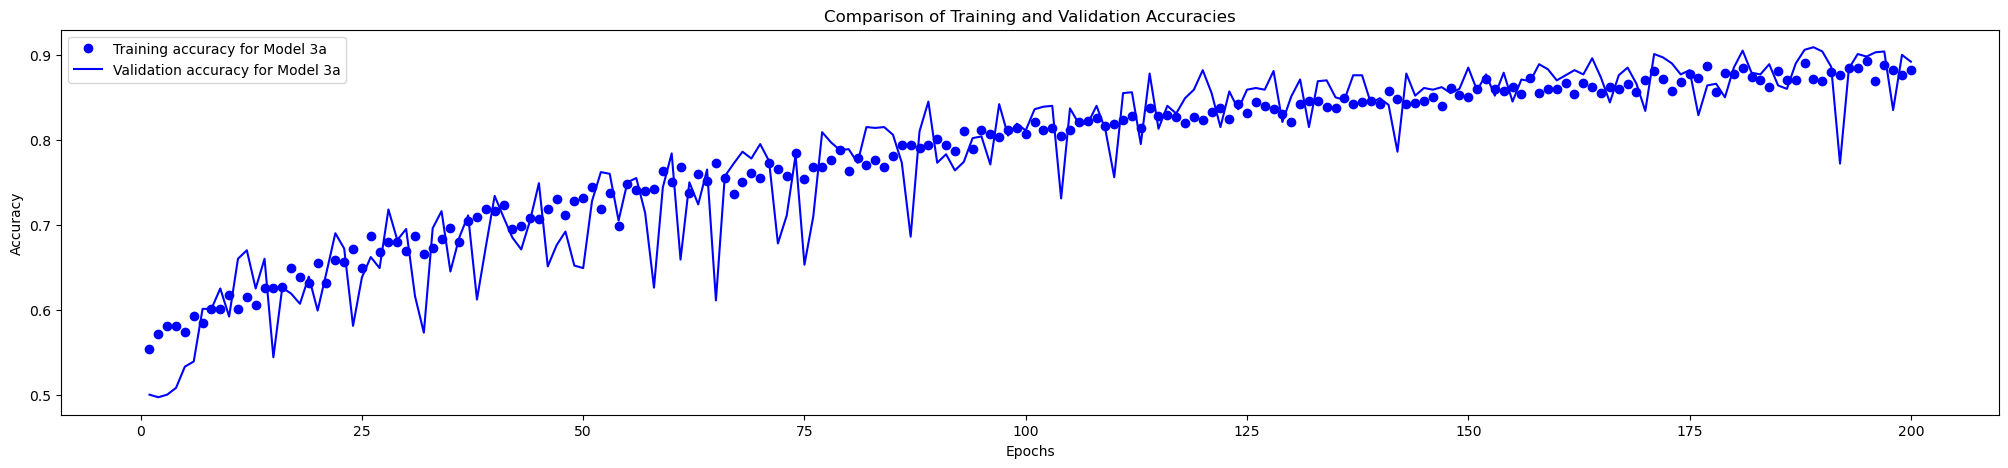

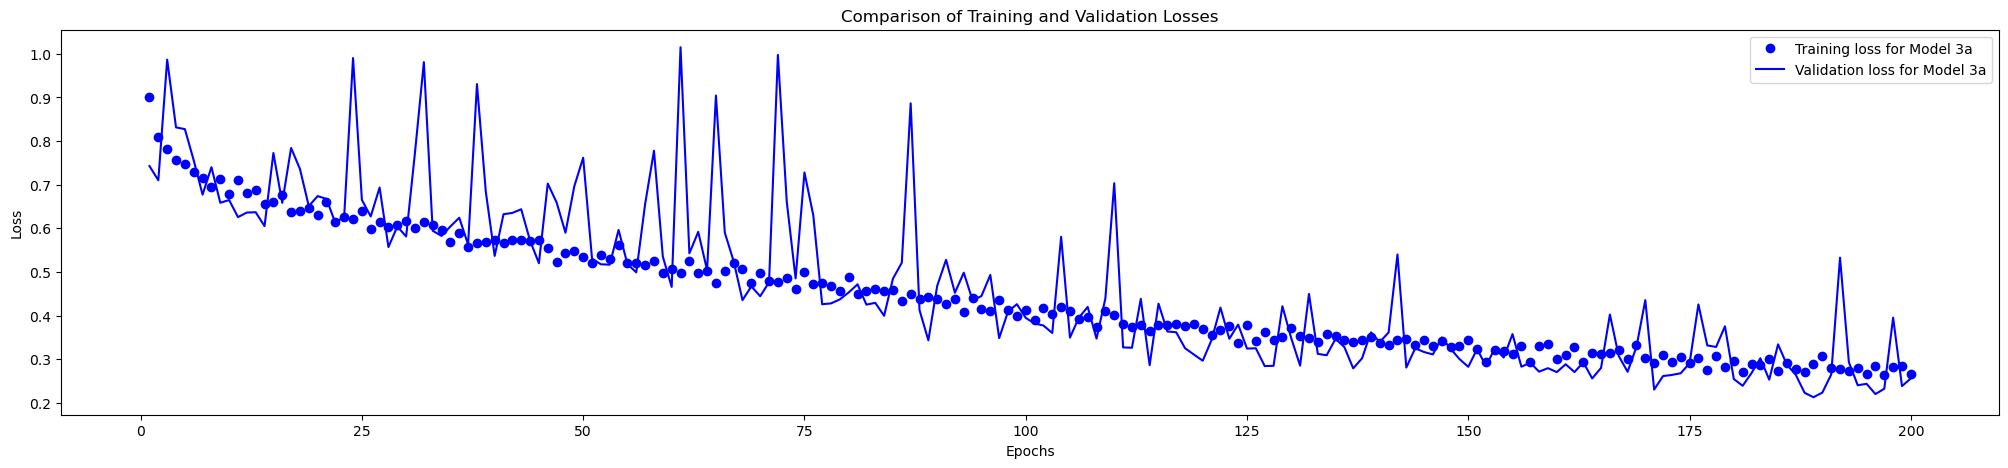

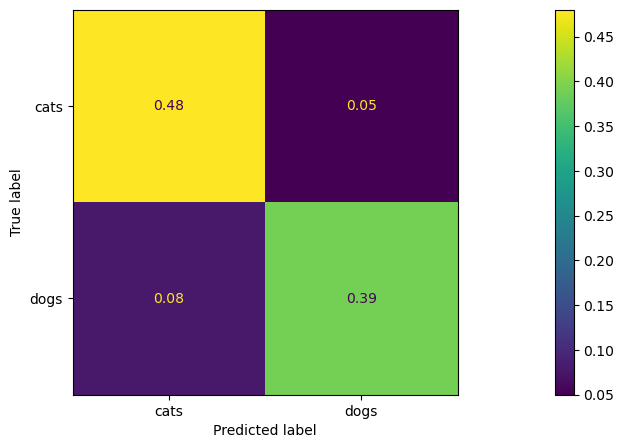

Accuracy: 0.87


In [86]:
plot_accuracy_comparison(history3_a, labels=['Model 3a'])
plot_loss_comparison(history3_a, labels=['Model 3a'])
plot_confusion_matrix(model3_a, validation_generator, 100)

In [87]:
history4_a = model4_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200
100/100 [==============================] - 17s 131ms/step - loss: 0.9332 - acc: 0.5605 - val_loss: 0.8276 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 13s 126ms/step - loss: 0.8747 - acc: 0.5680 - val_loss: 1.5071 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 11s 107ms/step - loss: 0.8774 - acc: 0.5580 - val_loss: 0.7986 - val_acc: 0.5170
Epoch 4/200
100/100 [==============================] - 13s 127ms/step - loss: 0.9128 - acc: 0.5485 - val_loss: 1.4896 - val_acc: 0.5030
Epoch 5/200
100/100 [==============================] - 11s 104ms/step - loss: 0.8611 - acc: 0.5725 - val_loss: 0.8085 - val_acc: 0.5560
Epoch 6/200
100/100 [==============================] - 13s 127ms/step - loss: 0.8461 - acc: 0.5665 - val_loss: 0.8699 - val_acc: 0.5390
Epoch 7/200
100/100 [==============================] - 13s 126ms/step - loss: 0.8340 - acc: 0.5715 - val_loss: 0.7486 - val_acc: 0.5900
Epoch 8/200
100/100 [===========================

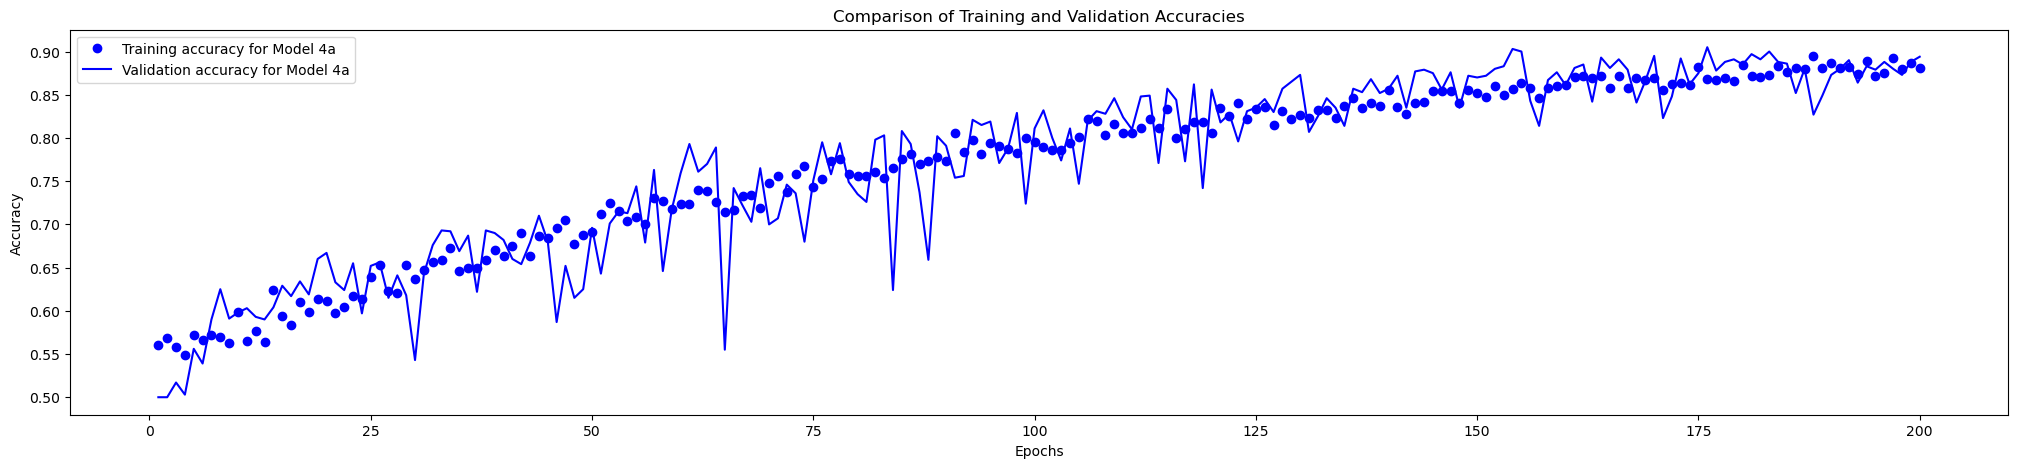

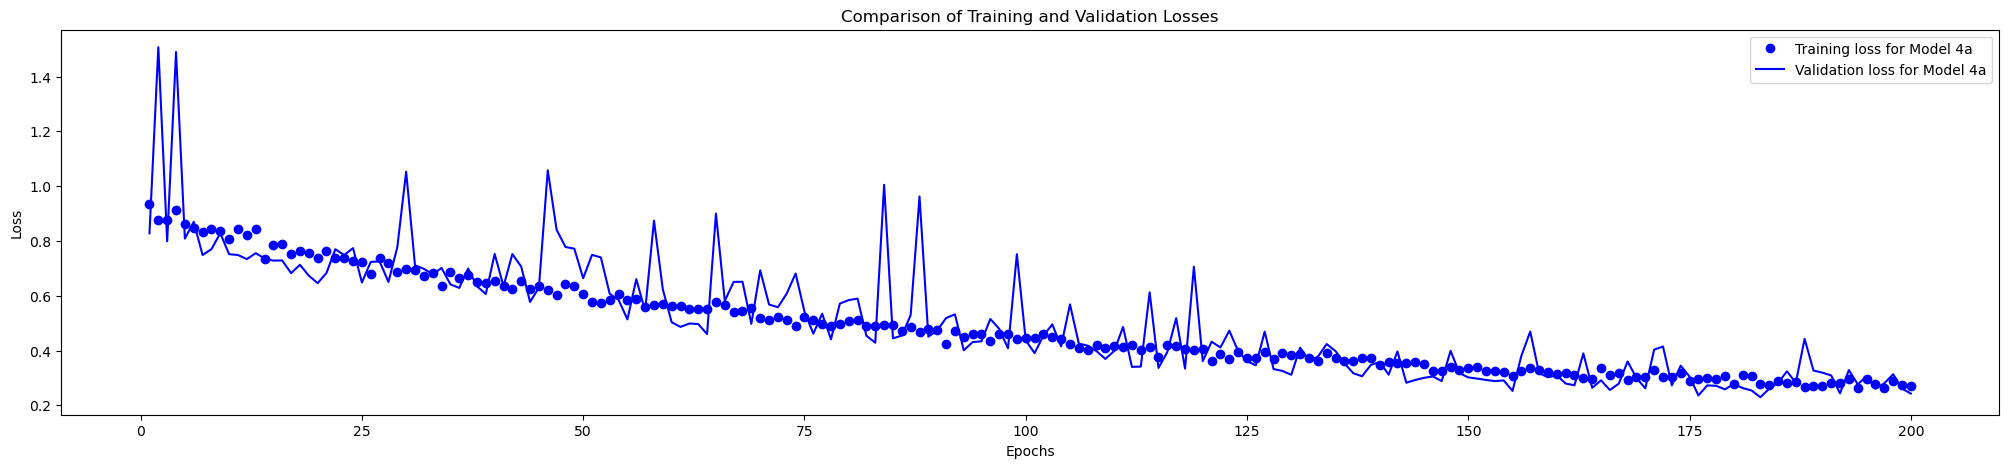

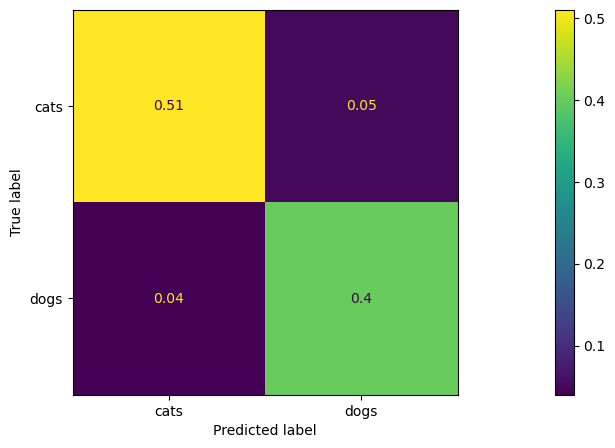

Accuracy: 0.91


In [88]:
plot_accuracy_comparison(history4_a, labels=['Model 4a'])
plot_loss_comparison(history4_a, labels=['Model 4a'])
plot_confusion_matrix(model4_a, validation_generator, 100)

In [89]:
history5_a = model5_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200


2024-04-14 05:20:38.147351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 17s 131ms/step - loss: 0.8504 - acc: 0.5595 - val_loss: 0.8562 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 10s 103ms/step - loss: 0.8679 - acc: 0.5560 - val_loss: 0.7217 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 12s 124ms/step - loss: 0.8420 - acc: 0.5550 - val_loss: 1.5196 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 13s 129ms/step - loss: 0.8293 - acc: 0.5735 - val_loss: 0.8179 - val_acc: 0.5070
Epoch 5/200
100/100 [==============================] - 11s 106ms/step - loss: 0.7931 - acc: 0.5920 - val_loss: 1.5120 - val_acc: 0.5020
Epoch 6/200
100/100 [==============================] - 13s 127ms/step - loss: 0.7745 - acc: 0.5960 - val_loss: 0.7615 - val_acc: 0.5570
Epoch 7/200
100/100 [==============================] - 11s 104ms/step - loss: 0.7936 - acc: 0.5820 - val_loss: 0.7531 - val_acc: 0.6140
Epoch 8/200
100/100 [==============================] - 13s 1

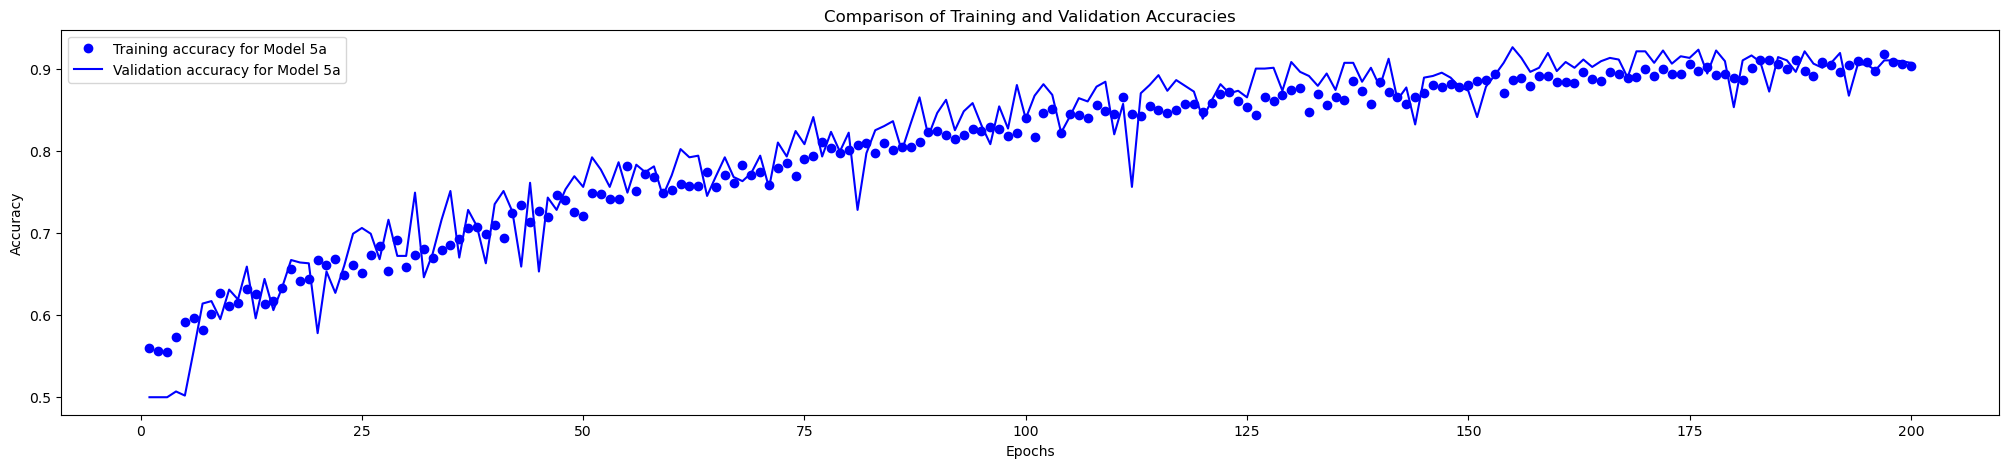

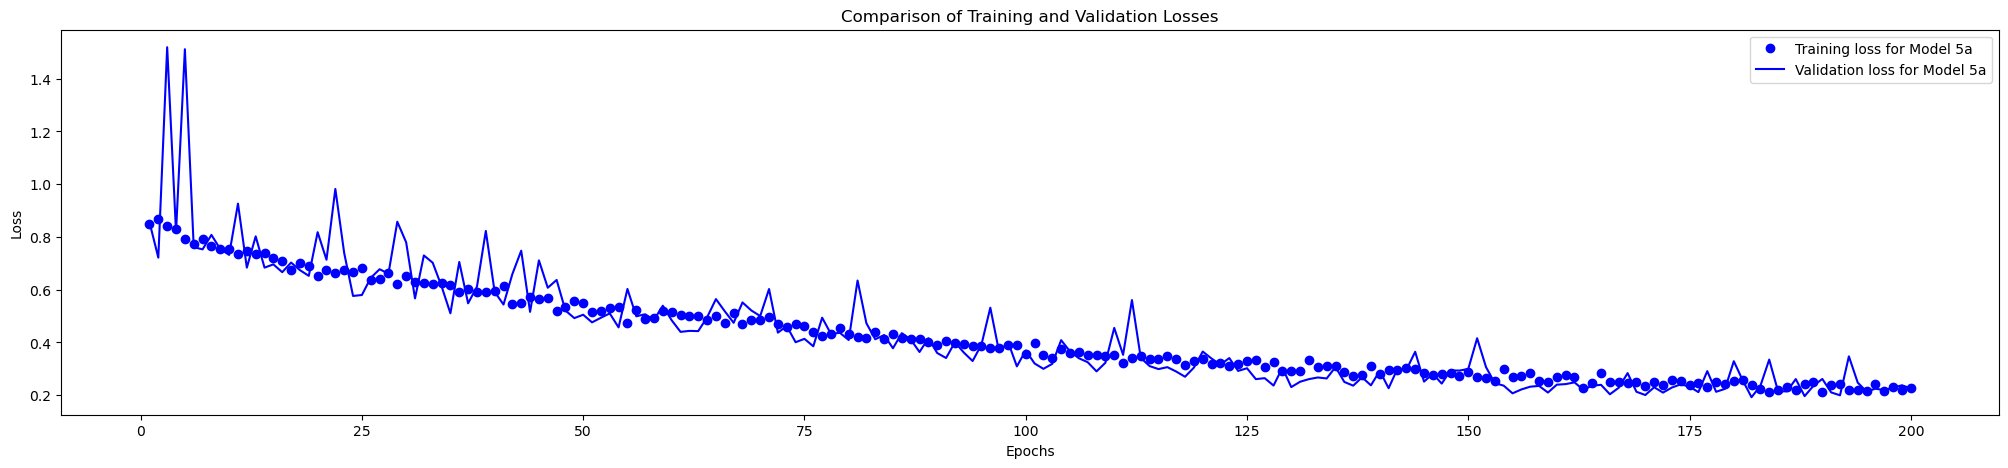

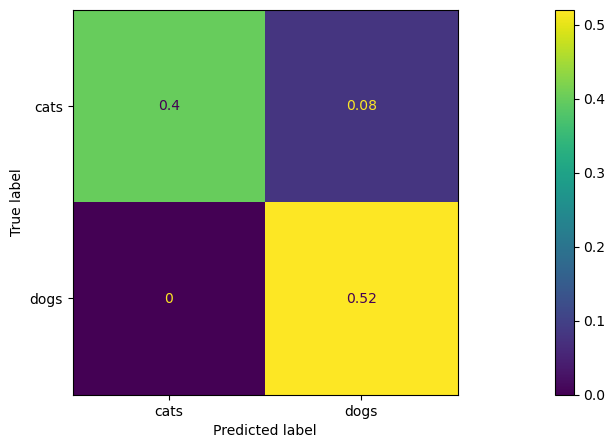

Accuracy: 0.92


In [90]:
plot_accuracy_comparison(history5_a, labels=['Model 5a'])
plot_loss_comparison(history5_a, labels=['Model 5a'])
plot_confusion_matrix(model5_a, validation_generator, 100)

## Save model

In [91]:
model1_a.save(models_dir + 'cats_and_dogs_1.keras')
model2_a.save(models_dir + 'cats_and_dogs_2.keras')
model3_a.save(models_dir + 'cats_and_dogs_3.keras')
model4_a.save(models_dir + 'cats_and_dogs_4.keras')
model5_a.save(models_dir + 'cats_and_dogs_5.keras')


## Visualizing the metrics

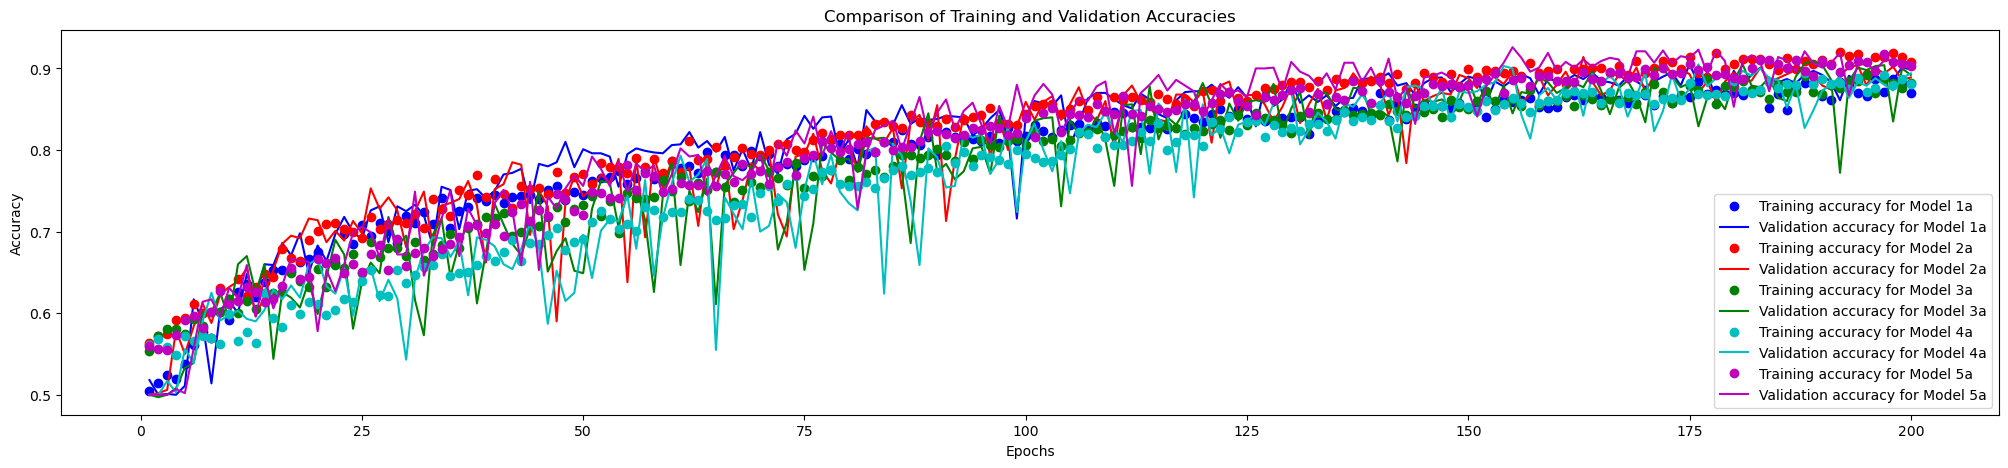

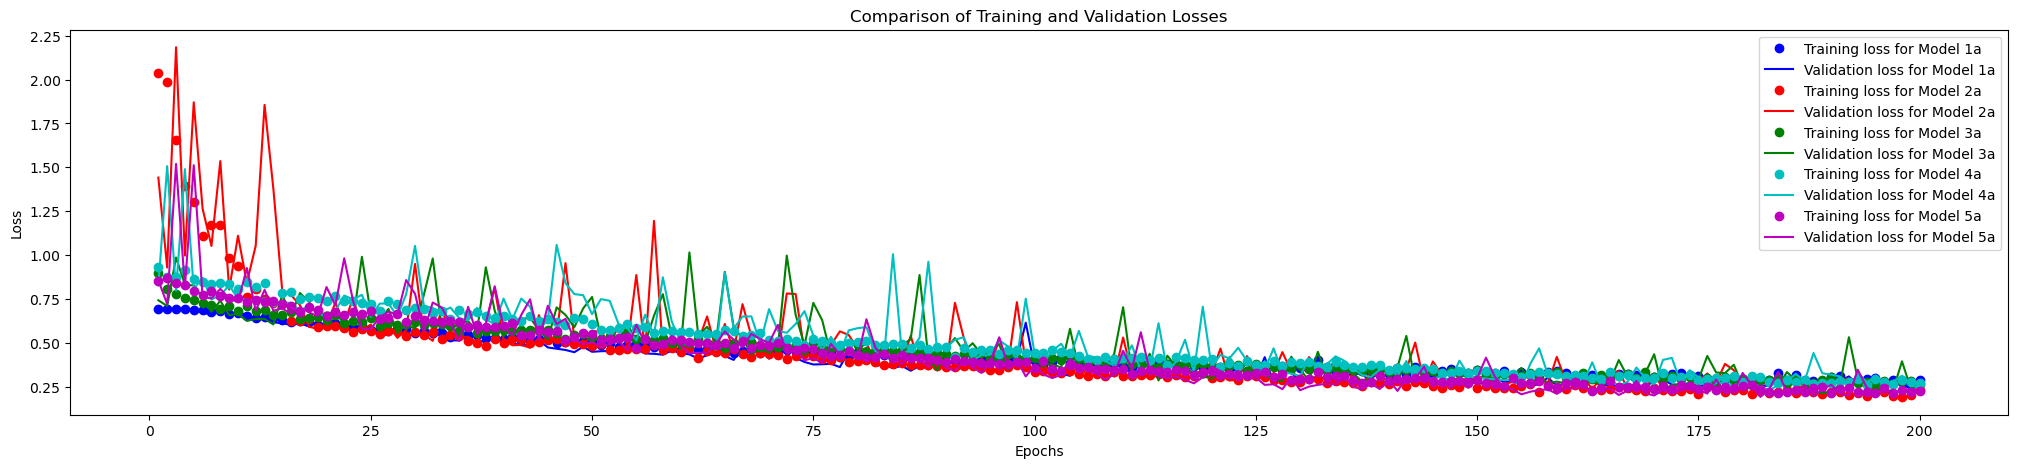

Max accuracy for model 1 is:  0.9049999713897705 , achieved in the  174 epoch.
Max accuracy for model 2 is:  0.9139999747276306 , achieved in the  162 epoch.
Max accuracy for model 3 is:  0.9089999794960022 , achieved in the  188 epoch.


In [92]:
plot_accuracy_comparison(history1_a, history2_a, history3_a, history4_a, history5_a, labels=['Model 1a', 'Model 2a', 'Model 3a', 'Model 4a', 'Model 5a'])
plot_loss_comparison(history1_a, history2_a, history3_a, history4_a, history5_a, labels=['Model 1a', 'Model 2a', 'Model 3a', 'Model 4a', 'Model 5a'])
print_val_accuracies(history1_a, history2_a, history3_a)


# Increase number of training samples - 12000

In [93]:
copy_all_images(max_train_size=12000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


In [94]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

Found 22000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## CNNs

In [95]:
img_rows, img_cols = 150, 150

model1_b = tf.keras.models.clone_model(model1_a)

model1_b.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1_b.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 17, 17, 128)      

In [96]:
model2_b = tf.keras.models.clone_model(model2_a)

model2_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2_b.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_20 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_42 (Conv2D)          (None, 70, 70, 128)       73856     
                                                                 
 batch_normalization_21 (Ba  (None, 70, 70, 128)      

In [97]:
model3_b = model6 = tf.keras.models.clone_model(model3_a)

model3_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3_b.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_46 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 conv2d_47 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 72, 72, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 70, 70, 64)        36928     
                                                                 
 batch_normalization_24 (Ba  (None, 70, 70, 64)        256       
 tchNormalization)                                    

In [98]:
model4_b = tf.keras.models.clone_model(model4_a)
model4_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4_b.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_53 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_54 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_28 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 46, 46, 64)       

In [99]:
model5_b = tf.keras.models.clone_model(model5_a)

model5_b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5_b.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_62 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_63 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_34 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 46, 46, 64)       

## Learning

In [100]:
history1_b = model1_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200
100/100 [==============================] - 14s 120ms/step - loss: 0.6919 - acc: 0.5100 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 13s 129ms/step - loss: 0.6912 - acc: 0.5240 - val_loss: 0.6891 - val_acc: 0.5150
Epoch 3/200
100/100 [==============================] - 12s 120ms/step - loss: 0.6891 - acc: 0.5570 - val_loss: 0.7072 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 12s 120ms/step - loss: 0.6844 - acc: 0.5505 - val_loss: 0.6809 - val_acc: 0.5810
Epoch 5/200
100/100 [==============================] - 12s 123ms/step - loss: 0.6726 - acc: 0.5815 - val_loss: 0.6814 - val_acc: 0.5610
Epoch 6/200
100/100 [==============================] - 12s 115ms/step - loss: 0.6771 - acc: 0.5760 - val_loss: 0.6682 - val_acc: 0.5910
Epoch 7/200
100/100 [==============================] - 12s 115ms/step - loss: 0.6568 - acc: 0.6105 - val_loss: 0.6691 - val_acc: 0.5820
Epoch 8/200
100/100 [===========================

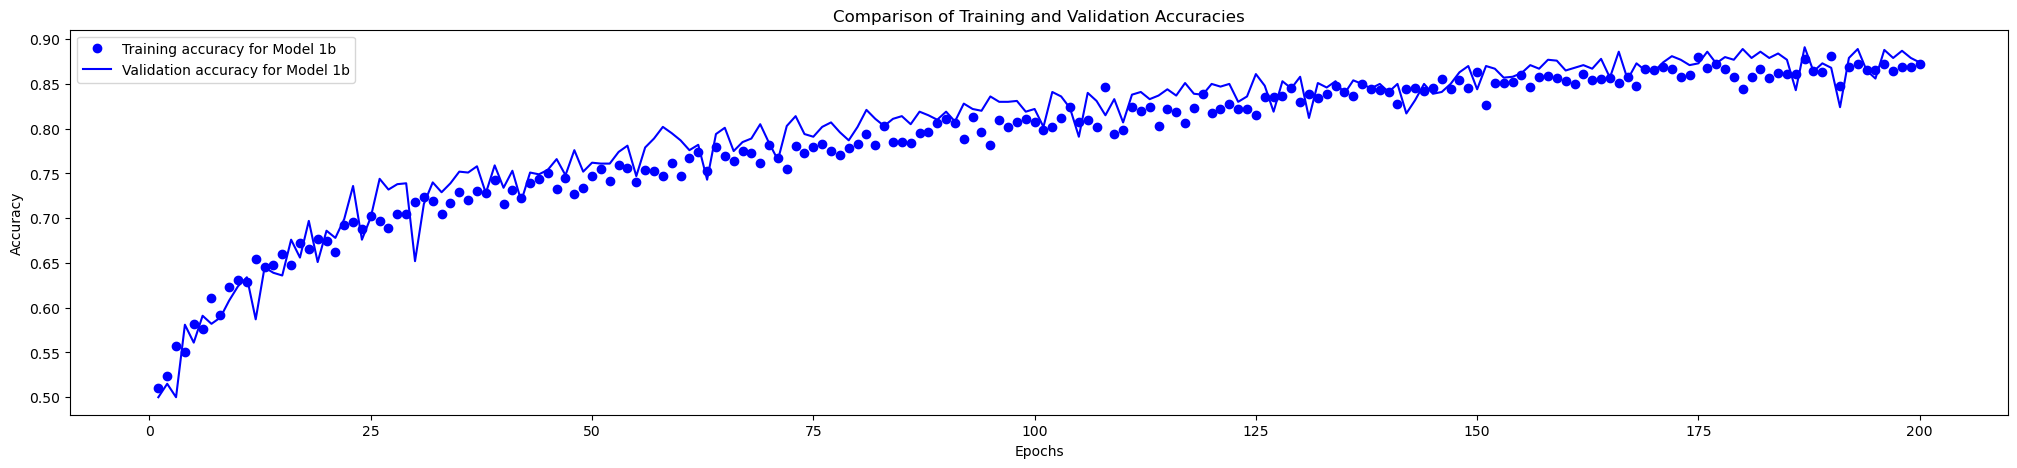

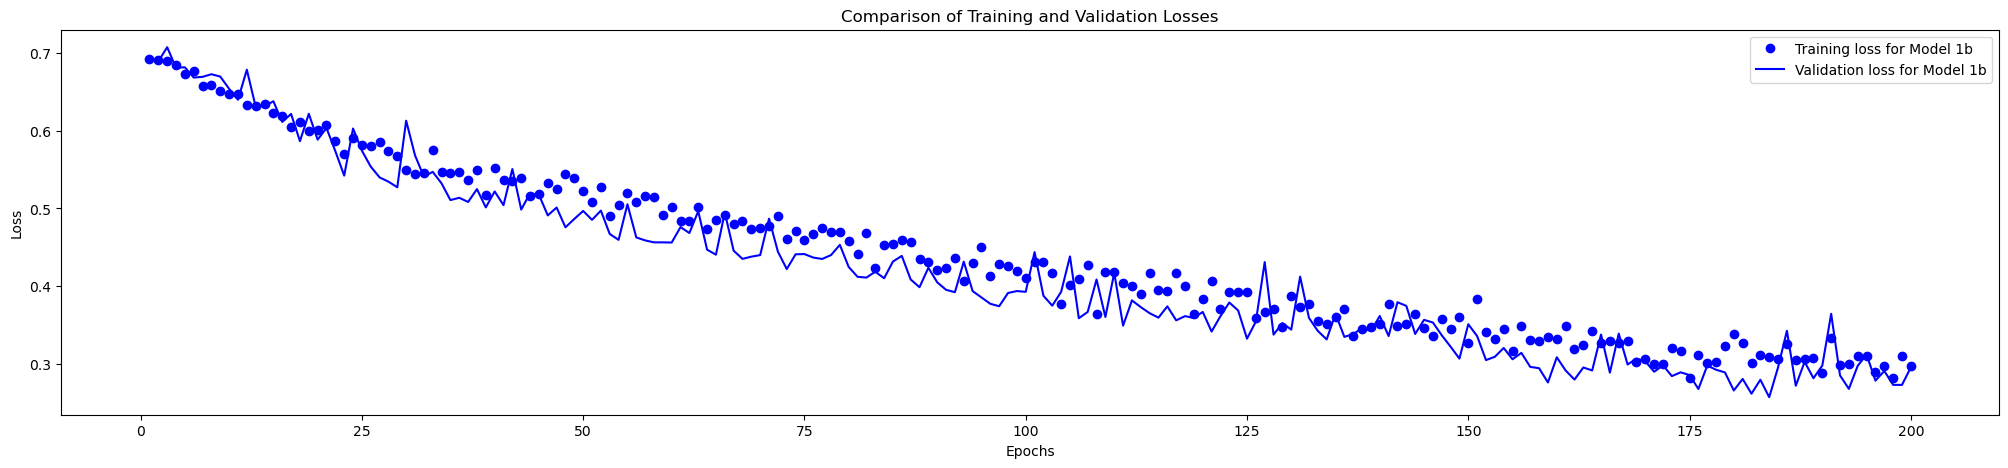

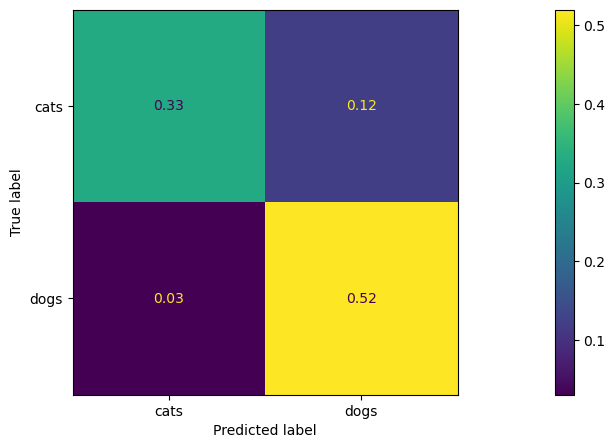

Accuracy: 0.8500000000000001


In [101]:
plot_accuracy_comparison(history1_b, labels=['Model 1b'])
plot_loss_comparison(history1_b, labels=['Model 1b'])
plot_confusion_matrix(model1_b, validation_generator, 100)

In [102]:
history2_b = model2_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200
 60/100 [=================>............] - ETA: 4s - loss: 2.0739 - acc: 0.5608

100/100 [==============================] - 16s 133ms/step - loss: 2.1247 - acc: 0.5580 - val_loss: 0.8679 - val_acc: 0.5010
Epoch 2/200
100/100 [==============================] - 12s 121ms/step - loss: 2.0409 - acc: 0.5605 - val_loss: 4.1350 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 12s 125ms/step - loss: 1.4646 - acc: 0.5930 - val_loss: 4.6969 - val_acc: 0.5020
Epoch 4/200
100/100 [==============================] - 13s 126ms/step - loss: 1.3618 - acc: 0.5805 - val_loss: 2.0473 - val_acc: 0.5550
Epoch 5/200
100/100 [==============================] - 12s 122ms/step - loss: 1.5449 - acc: 0.5860 - val_loss: 1.6828 - val_acc: 0.5900
Epoch 6/200
100/100 [==============================] - 13s 126ms/step - loss: 1.1698 - acc: 0.6070 - val_loss: 1.5636 - val_acc: 0.6130
Epoch 7/200
100/100 [==============================] - 13s 125ms/step - loss: 1.1554 - acc: 0.6135 - val_loss: 1.6933 - val_acc: 0.5660
Epoch 8/200
100/100 [==============================] - 12s 1

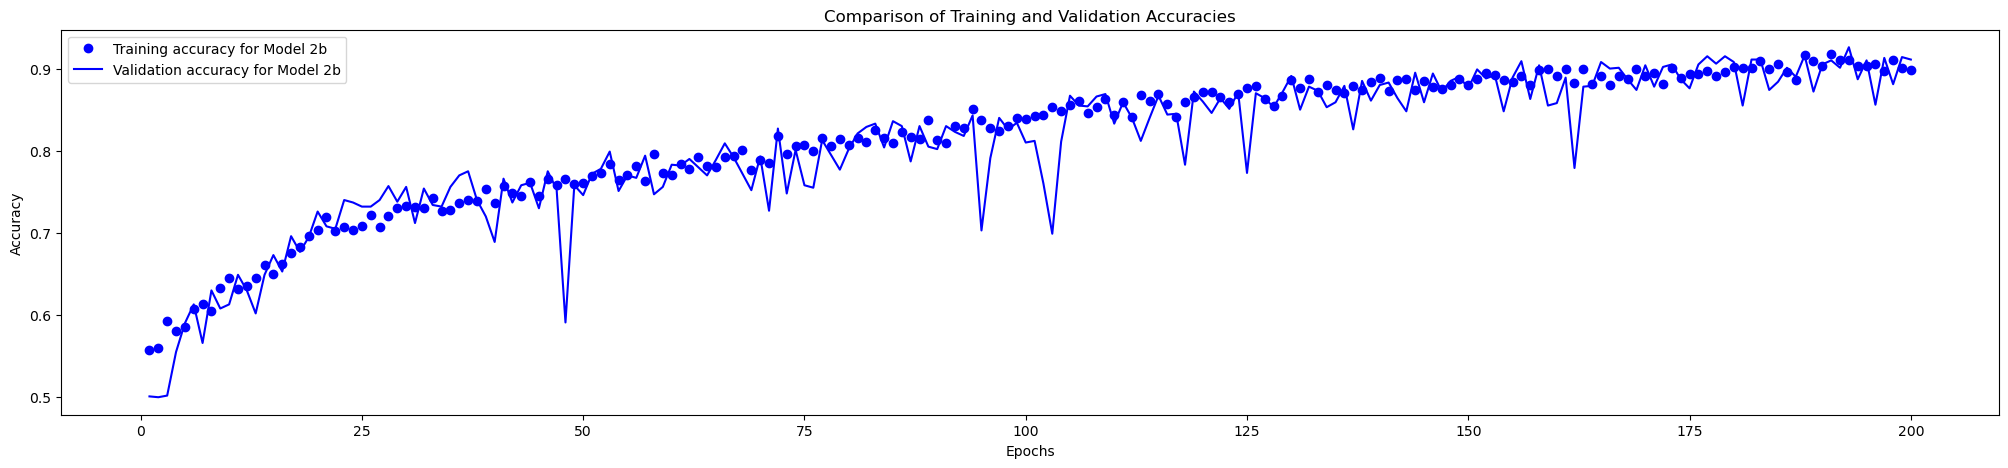

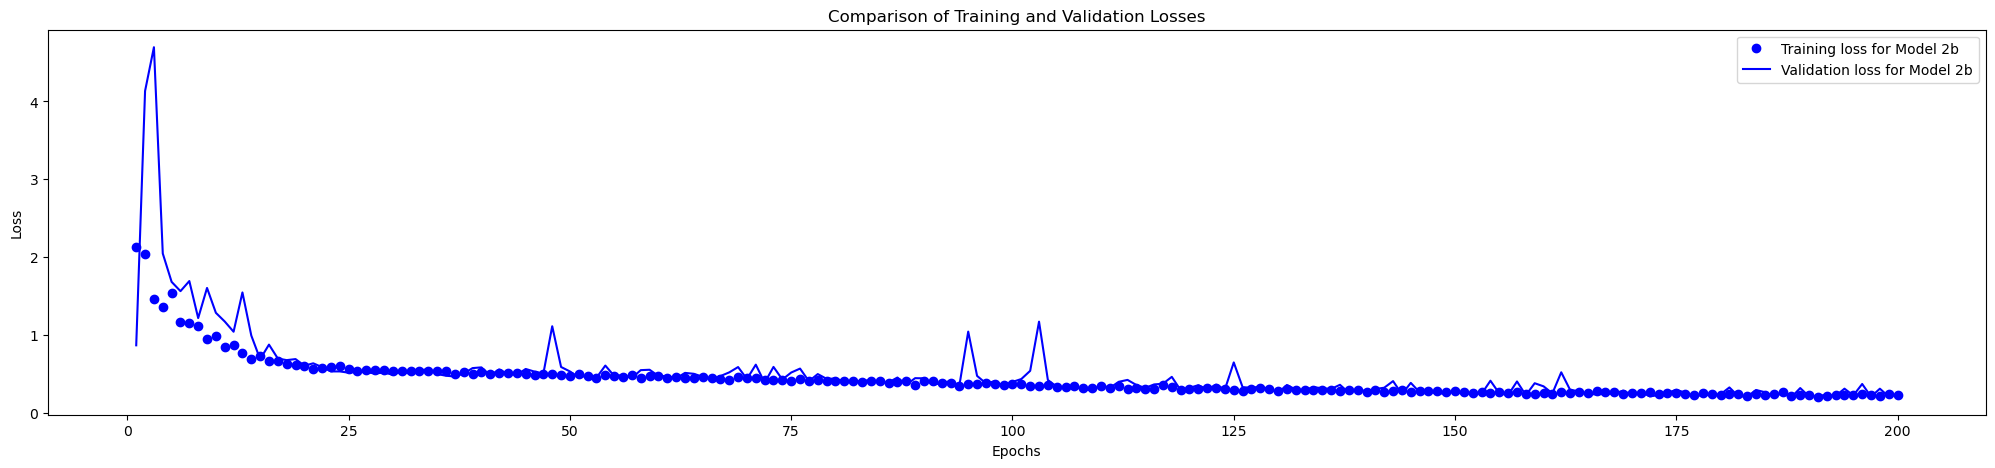

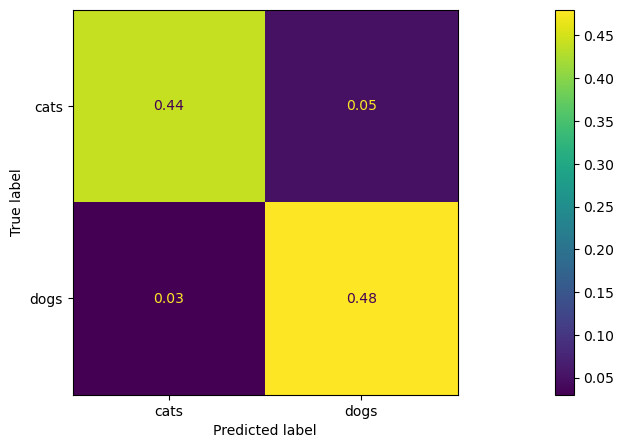

Accuracy: 0.9199999999999999


In [103]:
plot_accuracy_comparison(history2_b, labels=['Model 2b'])
plot_loss_comparison(history2_b, labels=['Model 2b'])
plot_confusion_matrix(model2_b, validation_generator, 100)

In [104]:
history3_b = model3_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200


2024-04-14 12:19:07.320844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 17s 133ms/step - loss: 0.9175 - acc: 0.5380 - val_loss: 0.7921 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 13s 126ms/step - loss: 0.8161 - acc: 0.5675 - val_loss: 1.0154 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 13s 126ms/step - loss: 0.7676 - acc: 0.5990 - val_loss: 1.0364 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 13s 126ms/step - loss: 0.7707 - acc: 0.5905 - val_loss: 1.2885 - val_acc: 0.5000
Epoch 5/200
100/100 [==============================] - 13s 124ms/step - loss: 0.7317 - acc: 0.5930 - val_loss: 0.8133 - val_acc: 0.5180
Epoch 6/200
100/100 [==============================] - 13s 127ms/step - loss: 0.7358 - acc: 0.5865 - val_loss: 0.7042 - val_acc: 0.5820
Epoch 7/200
100/100 [==============================] - 13s 125ms/step - loss: 0.7326 - acc: 0.5850 - val_loss: 0.7092 - val_acc: 0.5940
Epoch 8/200
100/100 [==============================] - 13s 1

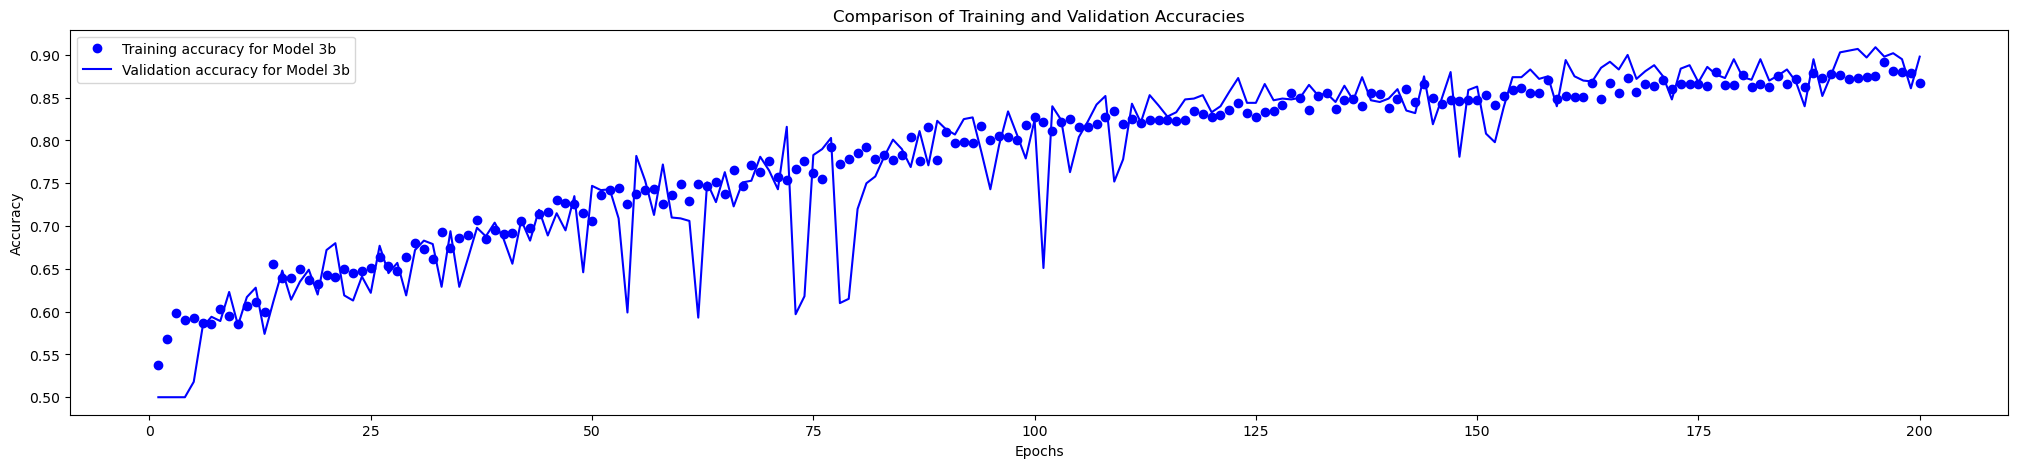

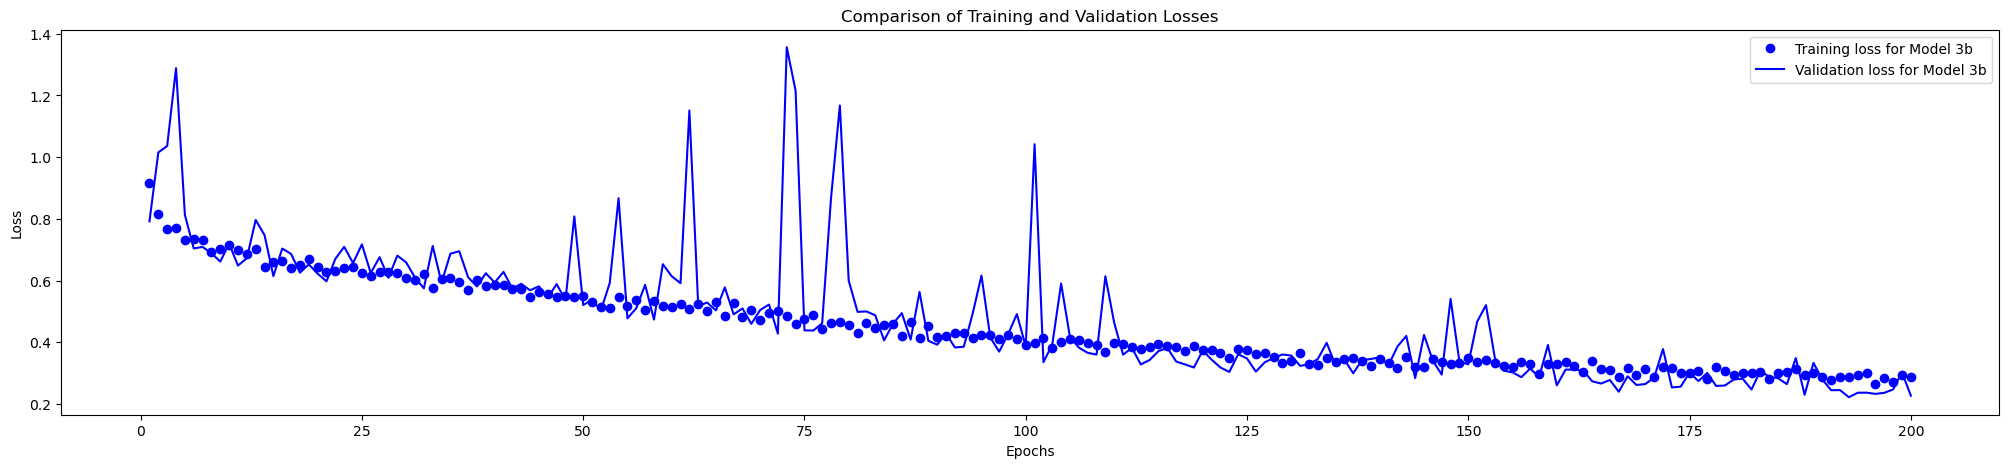

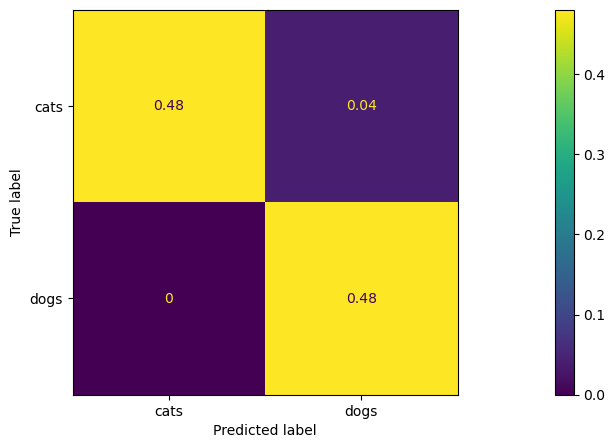

Accuracy: 0.96


In [105]:
plot_accuracy_comparison(history3_b, labels=['Model 3b'])
plot_loss_comparison(history3_b, labels=['Model 3b'])
plot_confusion_matrix(model3_b, validation_generator, 100)

In [106]:
history4_b = model4_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200
100/100 [==============================] - 21s 121ms/step - loss: 0.9056 - acc: 0.5420 - val_loss: 0.7529 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 12s 120ms/step - loss: 0.8887 - acc: 0.5735 - val_loss: 0.7246 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 12s 120ms/step - loss: 0.8764 - acc: 0.5485 - val_loss: 0.9575 - val_acc: 0.5020
Epoch 4/200
100/100 [==============================] - 12s 119ms/step - loss: 0.8338 - acc: 0.5685 - val_loss: 0.7509 - val_acc: 0.5400
Epoch 5/200
100/100 [==============================] - 12s 120ms/step - loss: 0.8231 - acc: 0.5785 - val_loss: 0.8235 - val_acc: 0.5470
Epoch 6/200
100/100 [==============================] - 12s 119ms/step - loss: 0.8024 - acc: 0.5980 - val_loss: 0.7062 - val_acc: 0.5990
Epoch 7/200
100/100 [==============================] - 12s 119ms/step - loss: 0.8224 - acc: 0.5865 - val_loss: 0.7305 - val_acc: 0.6000
Epoch 8/200
100/100 [===========================

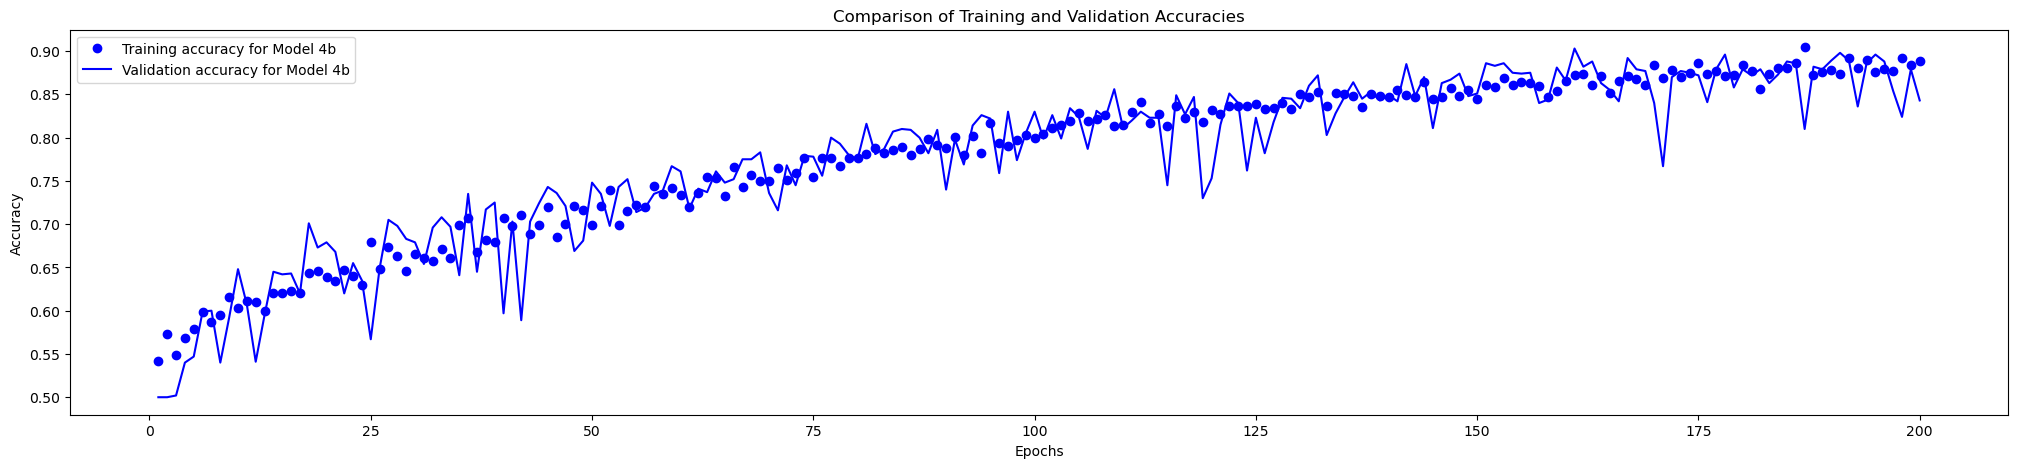

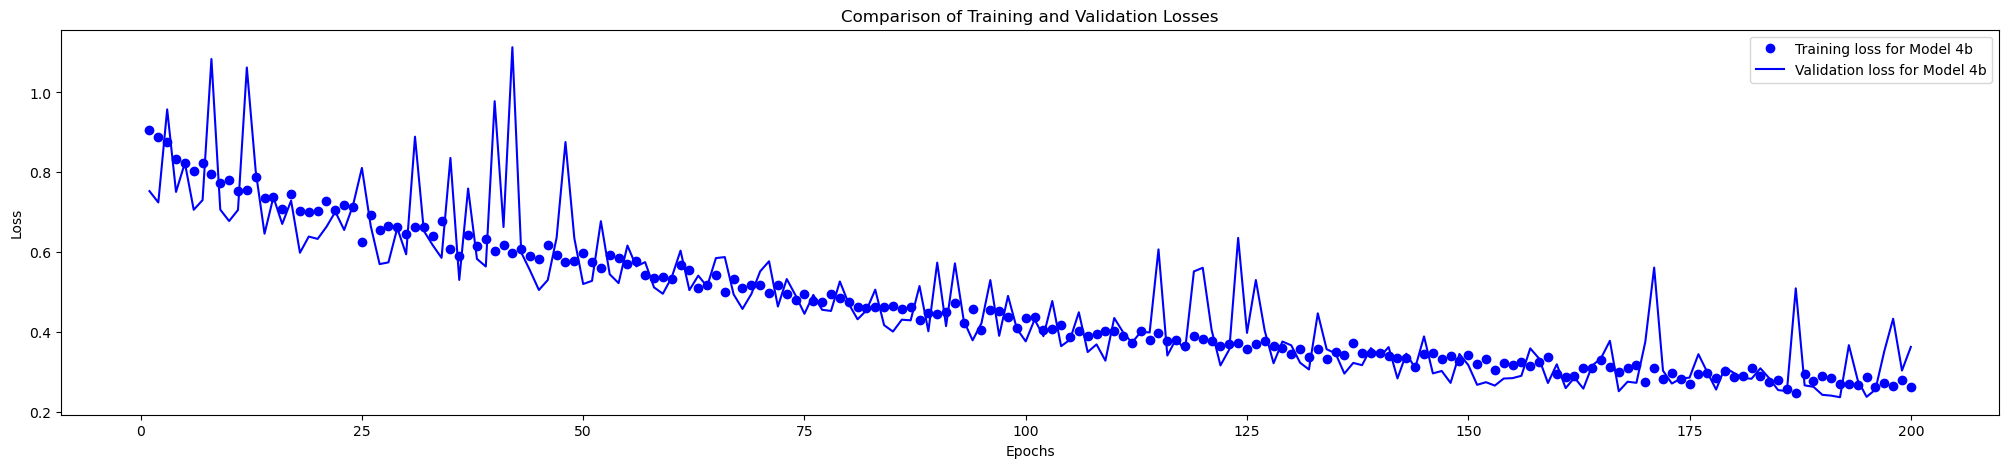

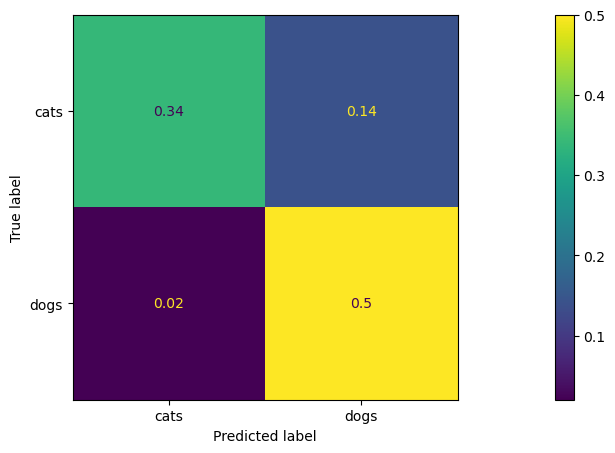

Accuracy: 0.8400000000000001


In [107]:
plot_accuracy_comparison(history4_b, labels=['Model 4b'])
plot_loss_comparison(history4_b, labels=['Model 4b'])
plot_confusion_matrix(model4_b, validation_generator, 100)

In [108]:
history5_b = model5_b.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200


2024-04-14 13:44:17.055695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 19s 122ms/step - loss: 0.8837 - acc: 0.5845 - val_loss: 0.6927 - val_acc: 0.5060
Epoch 2/200
100/100 [==============================] - 12s 121ms/step - loss: 0.8011 - acc: 0.5920 - val_loss: 0.8371 - val_acc: 0.5000
Epoch 3/200
  4/100 [>.............................] - ETA: 9s - loss: 0.8162 - acc: 0.6125

100/100 [==============================] - 12s 123ms/step - loss: 0.8362 - acc: 0.5615 - val_loss: 1.2306 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 13s 126ms/step - loss: 0.8215 - acc: 0.5775 - val_loss: 0.7450 - val_acc: 0.5210
Epoch 5/200
100/100 [==============================] - 13s 130ms/step - loss: 0.8125 - acc: 0.5810 - val_loss: 0.7388 - val_acc: 0.5380
Epoch 6/200
100/100 [==============================] - 12s 123ms/step - loss: 0.7993 - acc: 0.5770 - val_loss: 0.7242 - val_acc: 0.5810
Epoch 7/200
100/100 [==============================] - 12s 122ms/step - loss: 0.8175 - acc: 0.5620 - val_loss: 0.6983 - val_acc: 0.6250
Epoch 8/200
100/100 [==============================] - 12s 123ms/step - loss: 0.7495 - acc: 0.6040 - val_loss: 0.7720 - val_acc: 0.6170
Epoch 9/200
100/100 [==============================] - 12s 123ms/step - loss: 0.7580 - acc: 0.5995 - val_loss: 0.7376 - val_acc: 0.6040
Epoch 10/200
100/100 [==============================] - 13s 

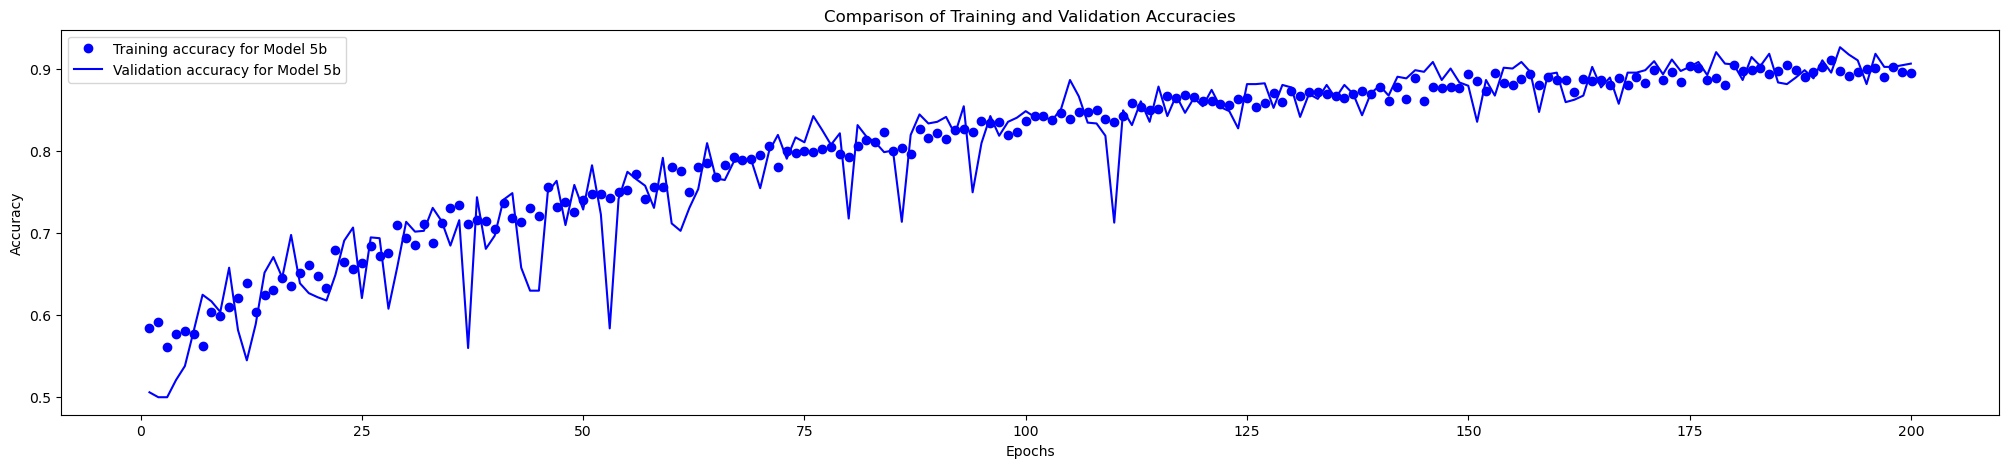

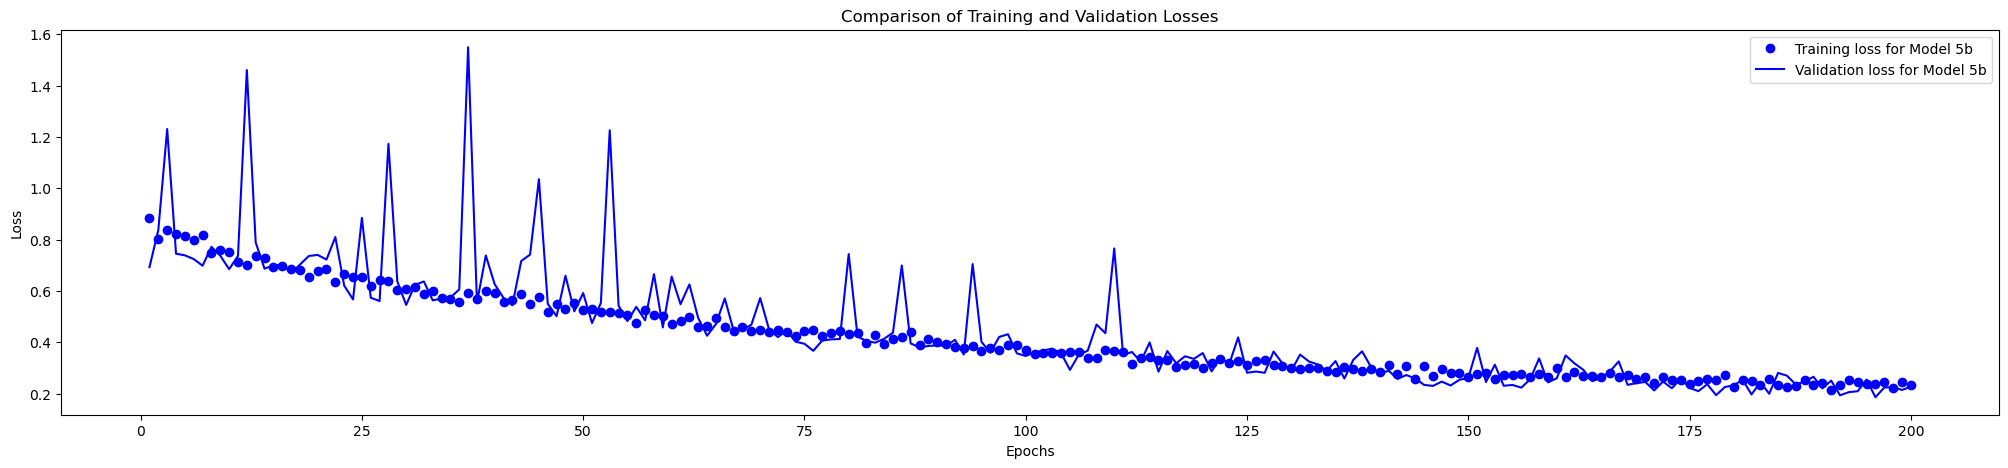

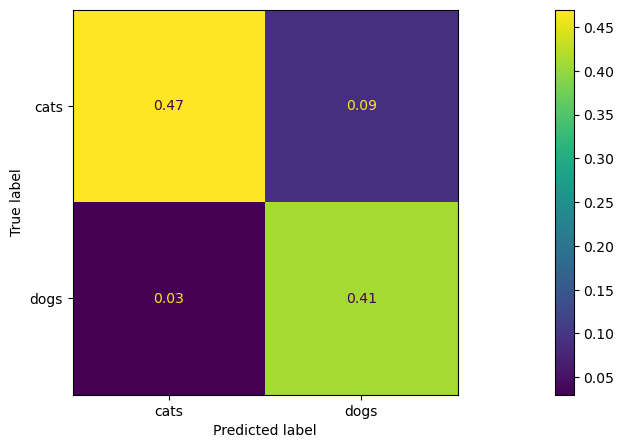

Accuracy: 0.8799999999999999


In [109]:
plot_accuracy_comparison(history5_b, labels=['Model 5b'])
plot_loss_comparison(history5_b, labels=['Model 5b'])
plot_confusion_matrix(model5_b, validation_generator, 100)

### Save the models

In [110]:
model1_b.save(models_dir + 'cats_and_dogs_1b.keras')
model2_b.save(models_dir + 'cats_and_dogs_2b.keras')
model3_b.save(models_dir + 'cats_and_dogs_3b.keras')
model4_b.save(models_dir + 'cats_and_dogs_4b.keras')
model5_b.save(models_dir + 'cats_and_dogs_5b.keras')


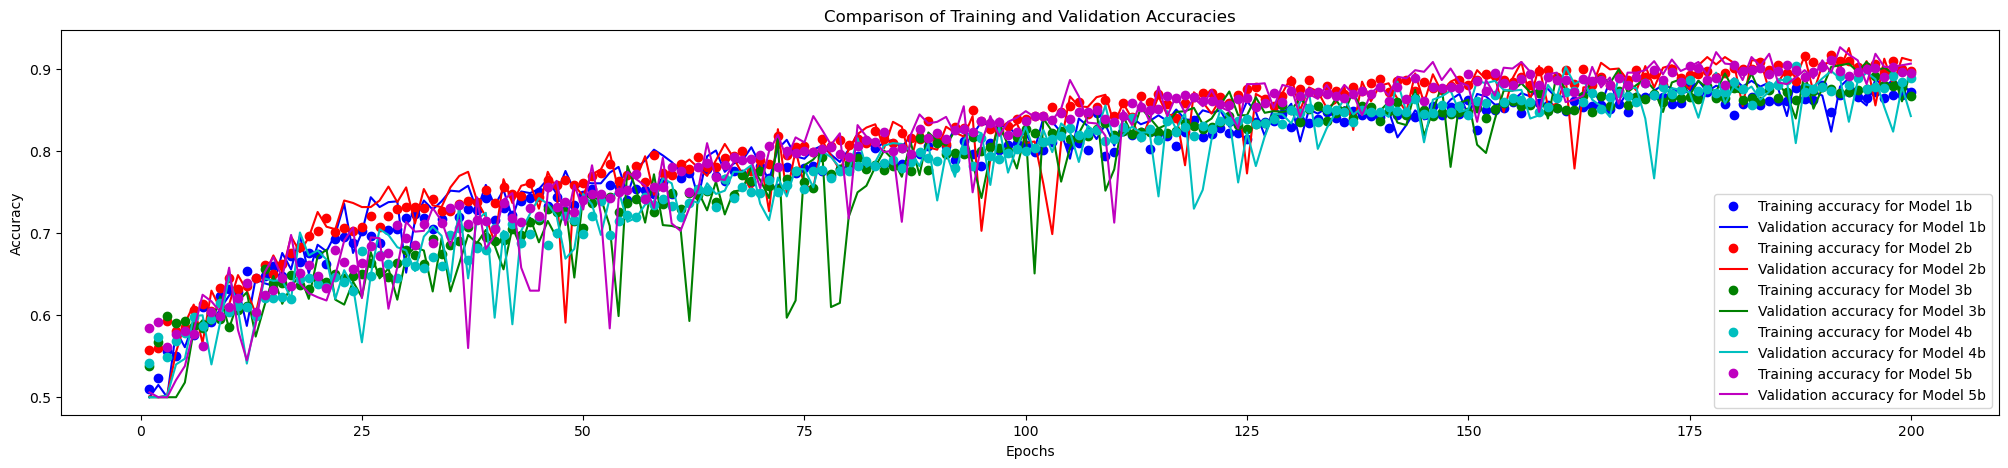

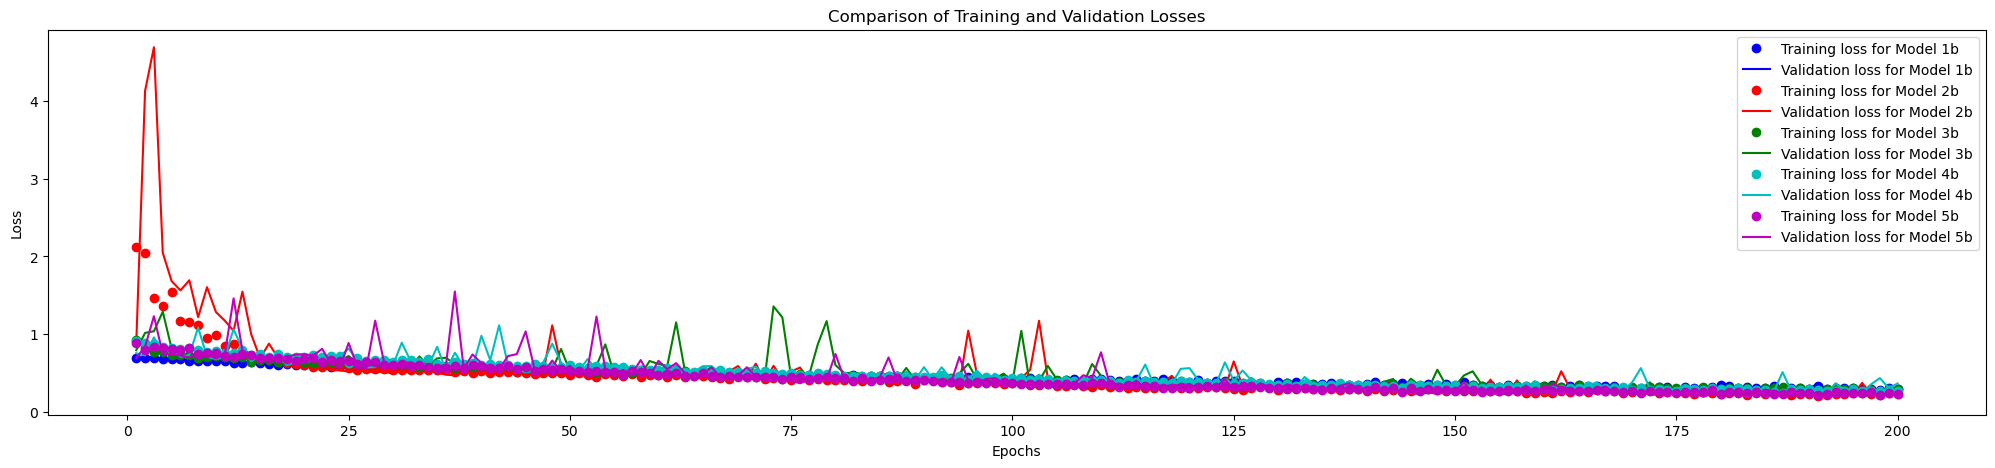

Max accuracy for model 1 is:  0.890999972820282 , achieved in the  186 epoch.
Max accuracy for model 2 is:  0.9259999990463257 , achieved in the  192 epoch.
Max accuracy for model 3 is:  0.9089999794960022 , achieved in the  194 epoch.


In [111]:
plot_accuracy_comparison(history1_b, history2_b, history3_b, history4_b, history5_b, labels=['Model 1b', 'Model 2b', 'Model 3b', 'Model 4b', 'Model 5b'])
plot_loss_comparison(history1_b, history2_b, history3_b, history4_b, history5_b, labels=['Model 1b', 'Model 2b', 'Model 3b', 'Model 4b', 'Model 5b'])
print_val_accuracies(history1_b, history2_b, history3_b)

# Increase number of training samples - 20000

In [112]:
copy_all_images(max_train_size=20000)

Dirs created
Train images copied
Validation images copied
Test images copied
All images copied


In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

img_rows, img_cols = 150, 150

Found 22000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## CNNs

In [114]:
model1_c = tf.keras.models.clone_model(model1_a)

model1_c.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1_c.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 17, 17, 128)      

In [115]:
model2_c = tf.keras.models.clone_model(model2_a)

model2_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2_c.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_20 (Ba  (None, 72, 72, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_42 (Conv2D)          (None, 70, 70, 128)       73856     
                                                                 
 batch_normalization_21 (Ba  (None, 70, 70, 128)      

In [116]:
model3_c = tf.keras.models.clone_model(model3_a)

model3_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3_c.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_46 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 conv2d_47 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 72, 72, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 70, 70, 64)        36928     
                                                                 
 batch_normalization_24 (Ba  (None, 70, 70, 64)        256       
 tchNormalization)                                    

In [117]:
model4_c = tf.keras.models.clone_model(model4_a)
model4_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4_c.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_53 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_54 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_28 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 46, 46, 64)       

In [118]:
model5_c = tf.keras.models.clone_model(model5_a)

model5_c.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5_c.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_62 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 conv2d_63 (Conv2D)          (None, 144, 144, 32)      9248      
                                                                 
 batch_normalization_34 (Ba  (None, 144, 144, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 46, 46, 64)       

## Learning

In [119]:
history1_c = model1_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200
100/100 [==============================] - 17s 128ms/step - loss: 0.6940 - acc: 0.4860 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 13s 125ms/step - loss: 0.6930 - acc: 0.5110 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 12s 120ms/step - loss: 0.6923 - acc: 0.5100 - val_loss: 0.6913 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 12s 121ms/step - loss: 0.6922 - acc: 0.5140 - val_loss: 0.6876 - val_acc: 0.5410
Epoch 5/200
100/100 [==============================] - 12s 122ms/step - loss: 0.6878 - acc: 0.5495 - val_loss: 0.6815 - val_acc: 0.5480
Epoch 6/200
100/100 [==============================] - 12s 121ms/step - loss: 0.6753 - acc: 0.5980 - val_loss: 0.6711 - val_acc: 0.5750
Epoch 7/200
100/100 [==============================] - 12s 120ms/step - loss: 0.6571 - acc: 0.6135 - val_loss: 0.6534 - val_acc: 0.6240
Epoch 8/200
100/100 [===========================

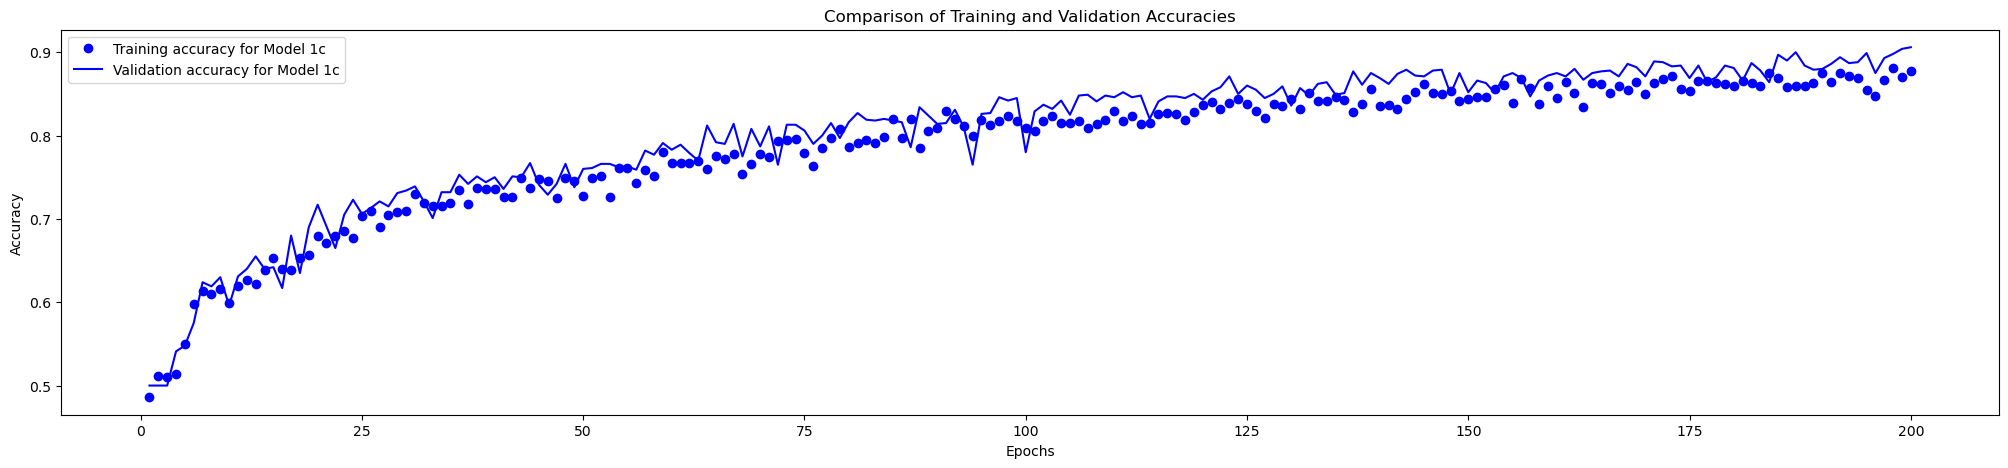

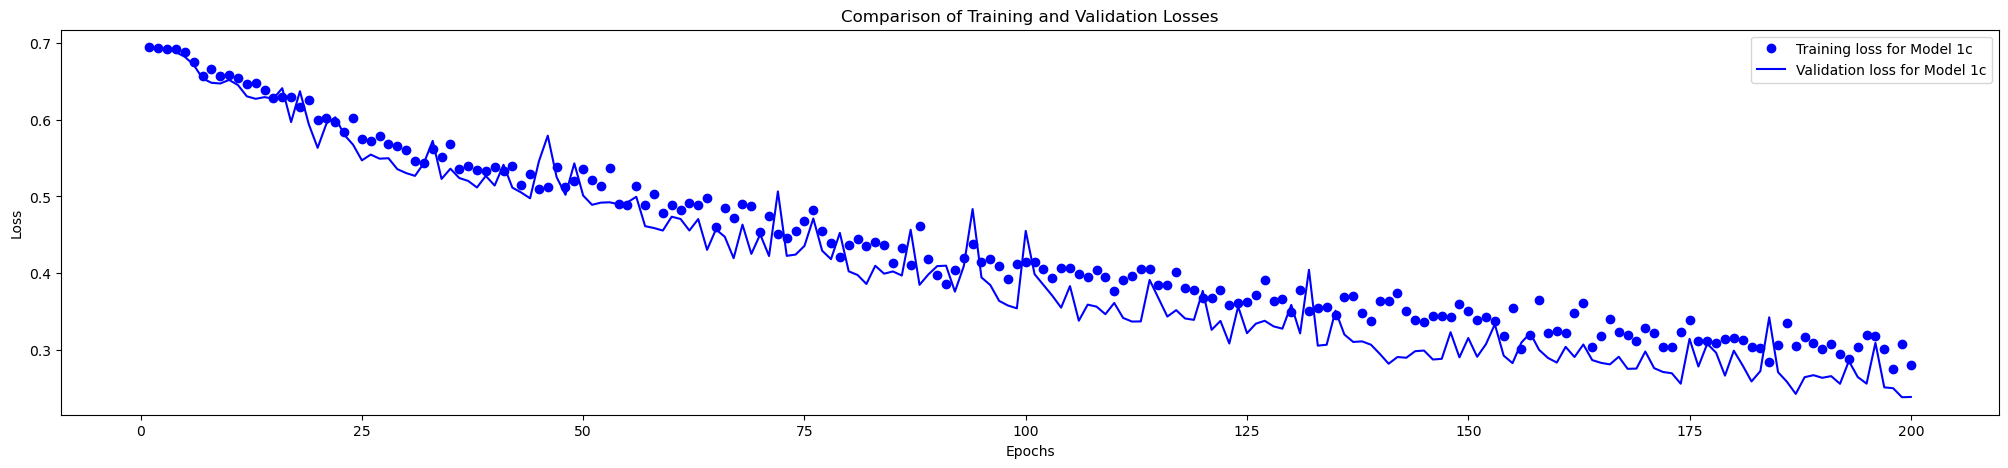

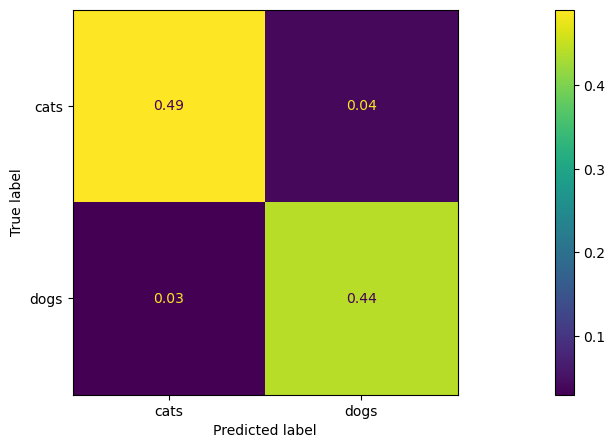

Accuracy: 0.9299999999999999


In [120]:
plot_accuracy_comparison(history1_c, labels=['Model 1c'])
plot_loss_comparison(history1_c, labels=['Model 1c'])
plot_confusion_matrix(model1_c, validation_generator, 100)

In [121]:
history2_c = model2_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200
100/100 [==============================] - 17s 132ms/step - loss: 2.1041 - acc: 0.5745 - val_loss: 1.7096 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 13s 130ms/step - loss: 1.8458 - acc: 0.5890 - val_loss: 1.4906 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 13s 128ms/step - loss: 1.5147 - acc: 0.6080 - val_loss: 1.6227 - val_acc: 0.4980
Epoch 4/200
100/100 [==============================] - 13s 130ms/step - loss: 1.3330 - acc: 0.5950 - val_loss: 1.8752 - val_acc: 0.5180
Epoch 5/200
100/100 [==============================] - 13s 133ms/step - loss: 1.3198 - acc: 0.6110 - val_loss: 1.6093 - val_acc: 0.5710
Epoch 6/200
100/100 [==============================] - 13s 131ms/step - loss: 1.2030 - acc: 0.6070 - val_loss: 1.9056 - val_acc: 0.5920
Epoch 7/200
100/100 [==============================] - 13s 132ms/step - loss: 0.9765 - acc: 0.6180 - val_loss: 0.9341 - val_acc: 0.6070
Epoch 8/200
100/100 [===========================

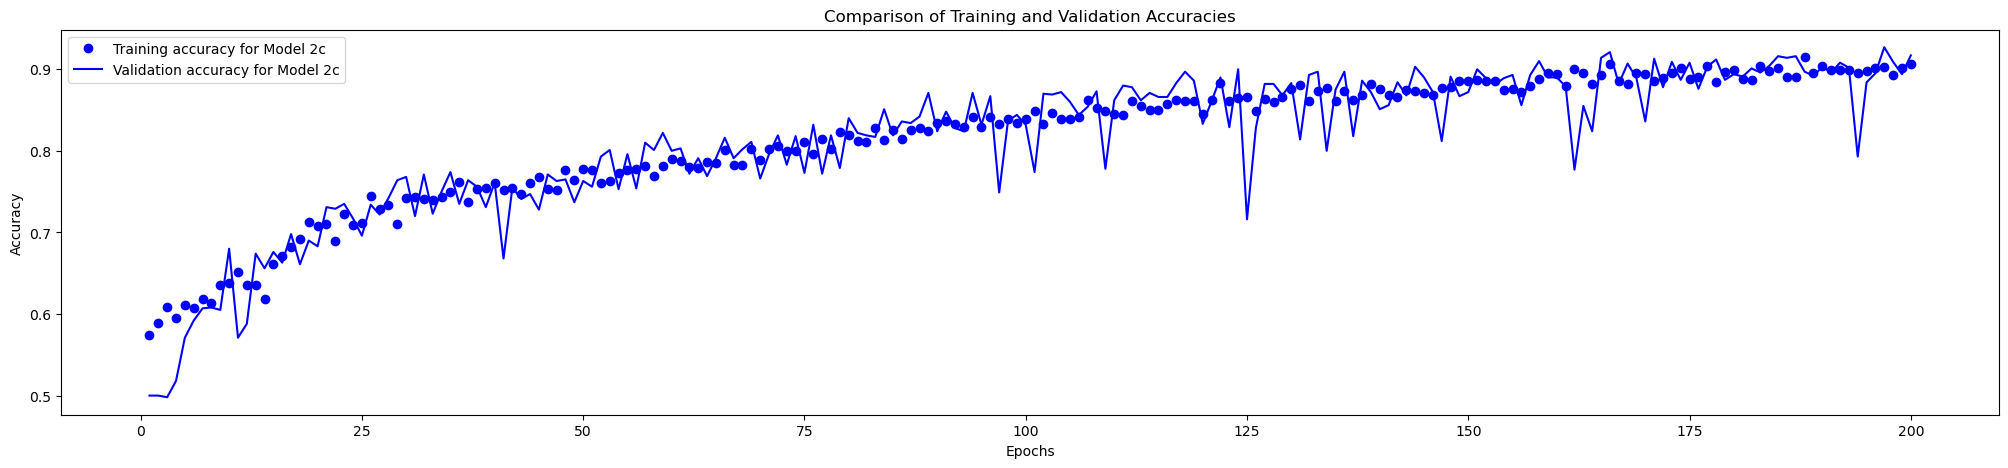

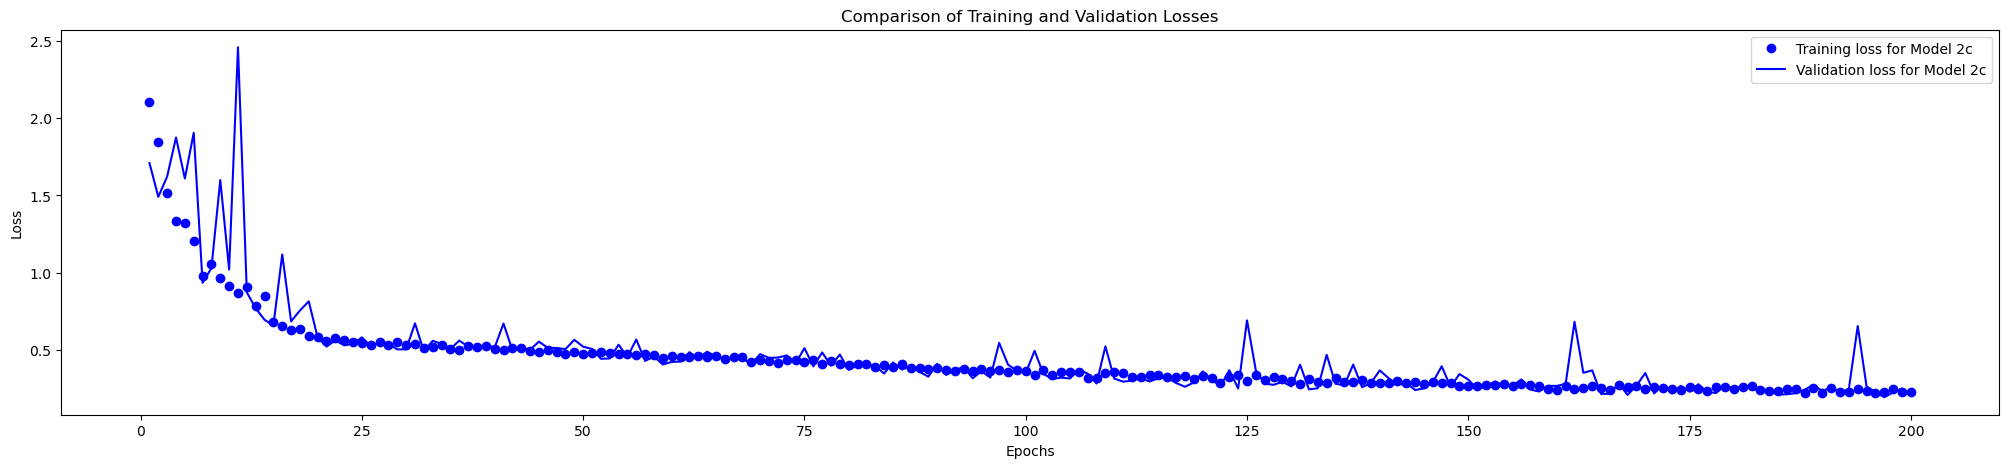

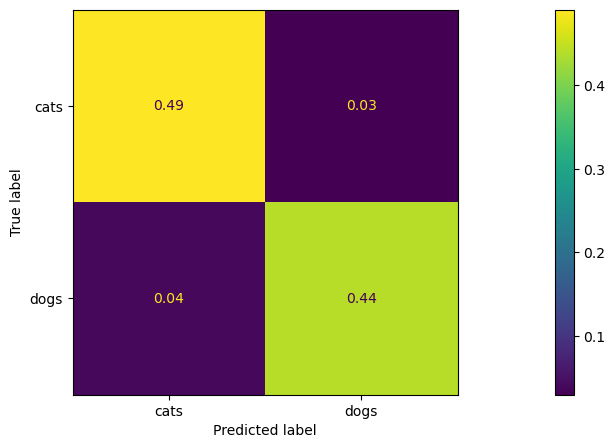

Accuracy: 0.9299999999999999


In [122]:
plot_accuracy_comparison(history2_c, labels=['Model 2c'])
plot_loss_comparison(history2_c, labels=['Model 2c'])
plot_confusion_matrix(model2_c, validation_generator, 100)

In [123]:

history3_c = model3_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200


2024-04-14 15:48:03.167341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-14 15:48:04.796764: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  3/100 [..............................] - ETA: 11s - loss: 1.0376 - acc: 0.4500

2024-04-14 15:48:05.168109: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-14 15:48:05.291237: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  5/100 [>.............................] - ETA: 11s - loss: 1.0086 - acc: 0.4900

2024-04-14 15:48:05.412120: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-14 15:48:05.531565: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  7/100 [=>............................] - ETA: 10s - loss: 0.9226 - acc: 0.5500

2024-04-14 15:48:05.643373: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-14 15:48:05.759005: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  9/100 [=>............................] - ETA: 10s - loss: 0.9568 - acc: 0.5333

2024-04-14 15:48:05.874823: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-14 15:48:05.997891: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 11/100 [==>...........................] - ETA: 10s - loss: 0.9410 - acc: 0.5273

2024-04-14 15:48:06.111613: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 456.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


100/100 [==============================] - 18s 137ms/step - loss: 0.9262 - acc: 0.5595 - val_loss: 0.7032 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 13s 128ms/step - loss: 0.8718 - acc: 0.5535 - val_loss: 0.9496 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 13s 132ms/step - loss: 0.8055 - acc: 0.5675 - val_loss: 0.9189 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 13s 133ms/step - loss: 0.7941 - acc: 0.5715 - val_loss: 0.9722 - val_acc: 0.5010
Epoch 5/200
100/100 [==============================] - 13s 130ms/step - loss: 0.7761 - acc: 0.5720 - val_loss: 0.7016 - val_acc: 0.5810
Epoch 6/200
100/100 [==============================] - 13s 134ms/step - loss: 0.7386 - acc: 0.5780 - val_loss: 0.7550 - val_acc: 0.5620
Epoch 7/200
100/100 [==============================] - 13s 131ms/step - loss: 0.7294 - acc: 0.5890 - val_loss: 0.6561 - val_acc: 0.6240
Epoch 8/200
100/100 [==============================] - 13s 1

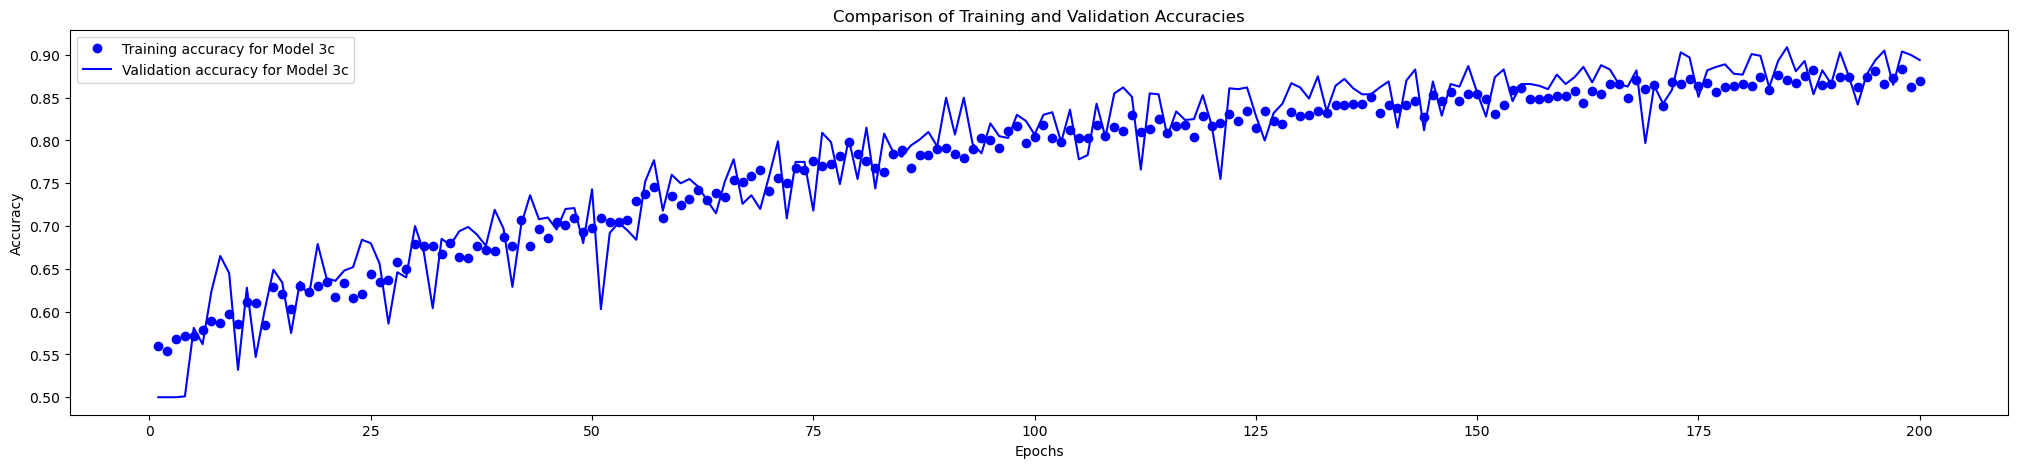

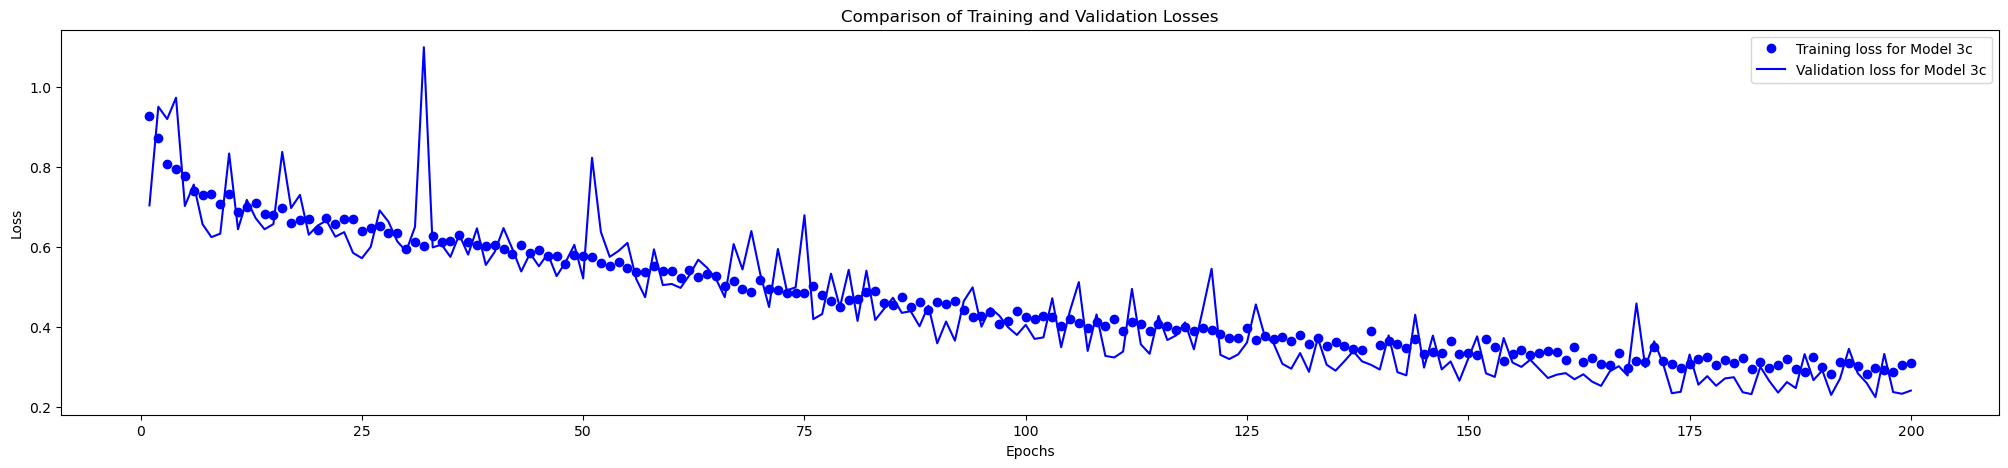

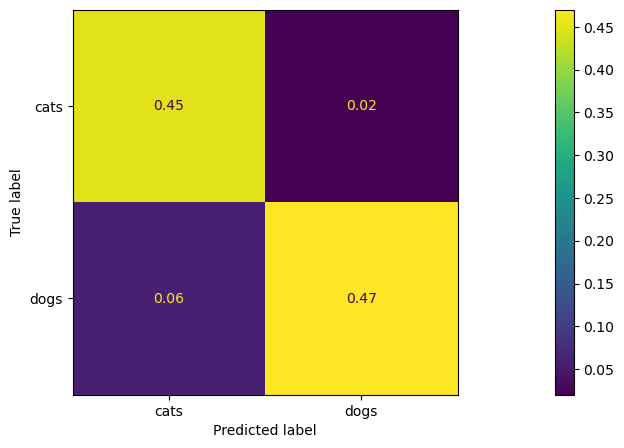

Accuracy: 0.9199999999999999


In [124]:
plot_accuracy_comparison(history3_c, labels=['Model 3c'])
plot_loss_comparison(history3_c, labels=['Model 3c'])
plot_confusion_matrix(model3_c, validation_generator, 100)

In [125]:
history4_c = model4_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200
100/100 [==============================] - 17s 119ms/step - loss: 0.8981 - acc: 0.5490 - val_loss: 0.7046 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 12s 125ms/step - loss: 0.8880 - acc: 0.5475 - val_loss: 0.7923 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 12s 118ms/step - loss: 0.8368 - acc: 0.5775 - val_loss: 0.6848 - val_acc: 0.5610
Epoch 4/200
100/100 [==============================] - 13s 126ms/step - loss: 0.8261 - acc: 0.5910 - val_loss: 0.9037 - val_acc: 0.5230
Epoch 5/200
100/100 [==============================] - 13s 125ms/step - loss: 0.8382 - acc: 0.5695 - val_loss: 1.0113 - val_acc: 0.5320
Epoch 6/200
100/100 [==============================] - 12s 115ms/step - loss: 0.8116 - acc: 0.5780 - val_loss: 0.7247 - val_acc: 0.5700
Epoch 7/200
100/100 [==============================] - 13s 126ms/step - loss: 0.8410 - acc: 0.5700 - val_loss: 0.7821 - val_acc: 0.5760
Epoch 8/200
100/100 [===========================

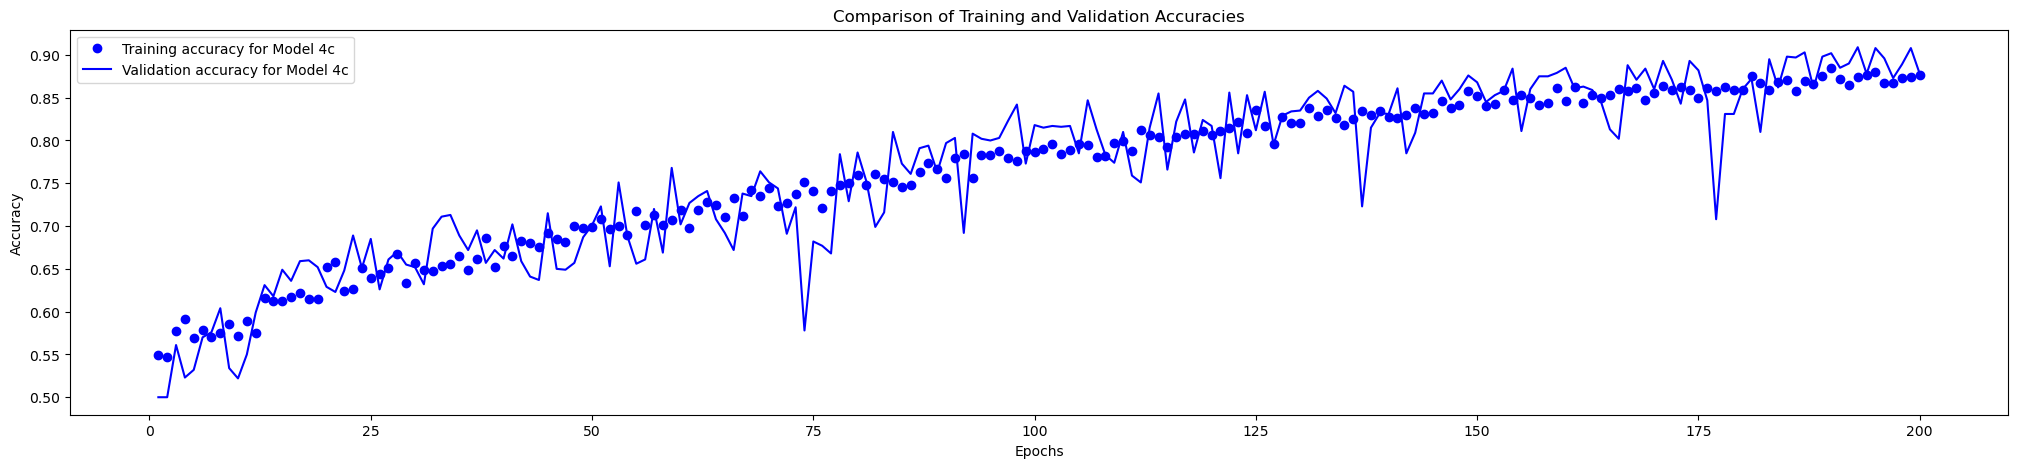

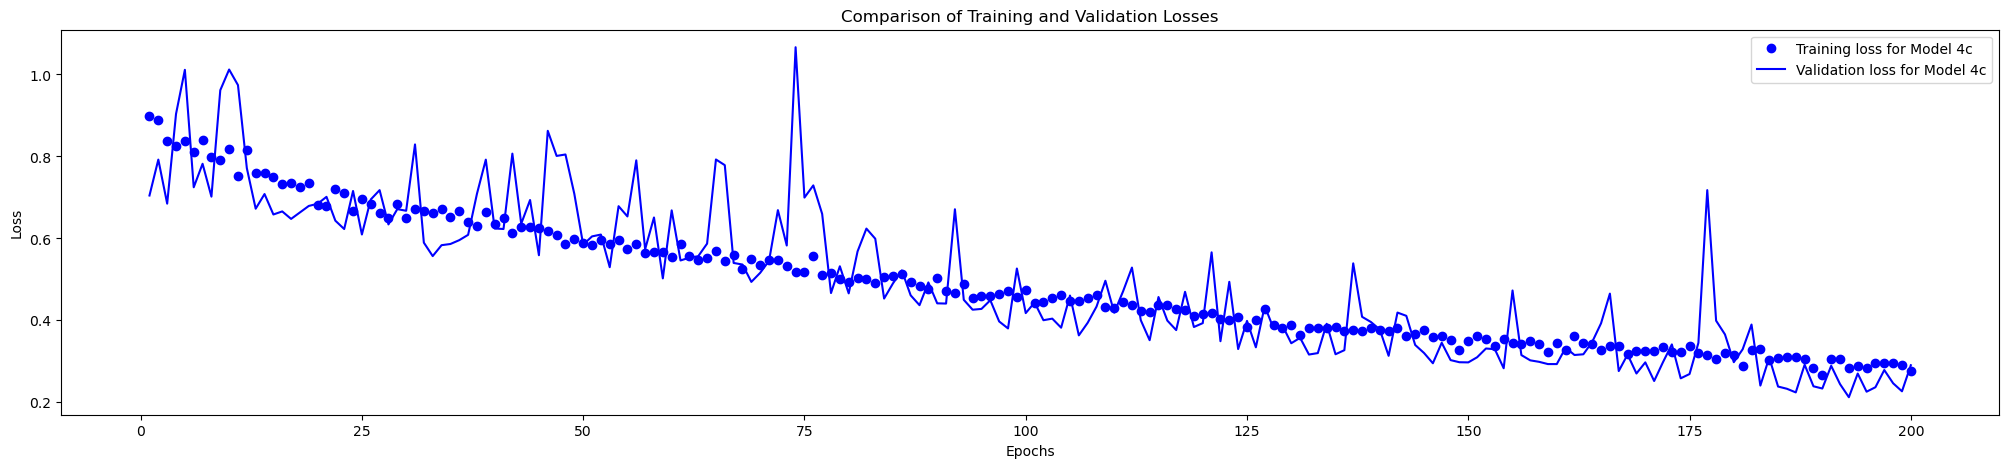

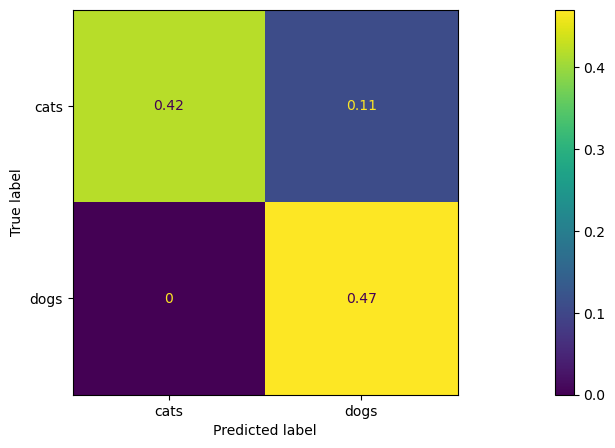

Accuracy: 0.8899999999999999


In [126]:
plot_accuracy_comparison(history4_c, labels=['Model 4c'])
plot_loss_comparison(history4_c, labels=['Model 4c'])
plot_confusion_matrix(model4_c, validation_generator, 100)

In [127]:
history5_c = model5_c.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/200


2024-04-14 17:15:14.022688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 18s 124ms/step - loss: 0.8873 - acc: 0.5535 - val_loss: 0.7026 - val_acc: 0.5000
Epoch 2/200
100/100 [==============================] - 12s 120ms/step - loss: 0.7949 - acc: 0.5975 - val_loss: 1.4748 - val_acc: 0.5000
Epoch 3/200
100/100 [==============================] - 13s 124ms/step - loss: 0.8417 - acc: 0.5665 - val_loss: 1.6326 - val_acc: 0.5000
Epoch 4/200
100/100 [==============================] - 12s 120ms/step - loss: 0.8104 - acc: 0.5740 - val_loss: 1.2192 - val_acc: 0.5010
Epoch 5/200
100/100 [==============================] - 13s 134ms/step - loss: 0.8040 - acc: 0.5935 - val_loss: 0.7702 - val_acc: 0.5640
Epoch 6/200
100/100 [==============================] - 12s 120ms/step - loss: 0.7721 - acc: 0.6045 - val_loss: 0.6677 - val_acc: 0.6100
Epoch 7/200
100/100 [==============================] - 13s 128ms/step - loss: 0.7377 - acc: 0.6035 - val_loss: 0.7111 - val_acc: 0.6450
Epoch 8/200
100/100 [==============================] - 13s 1

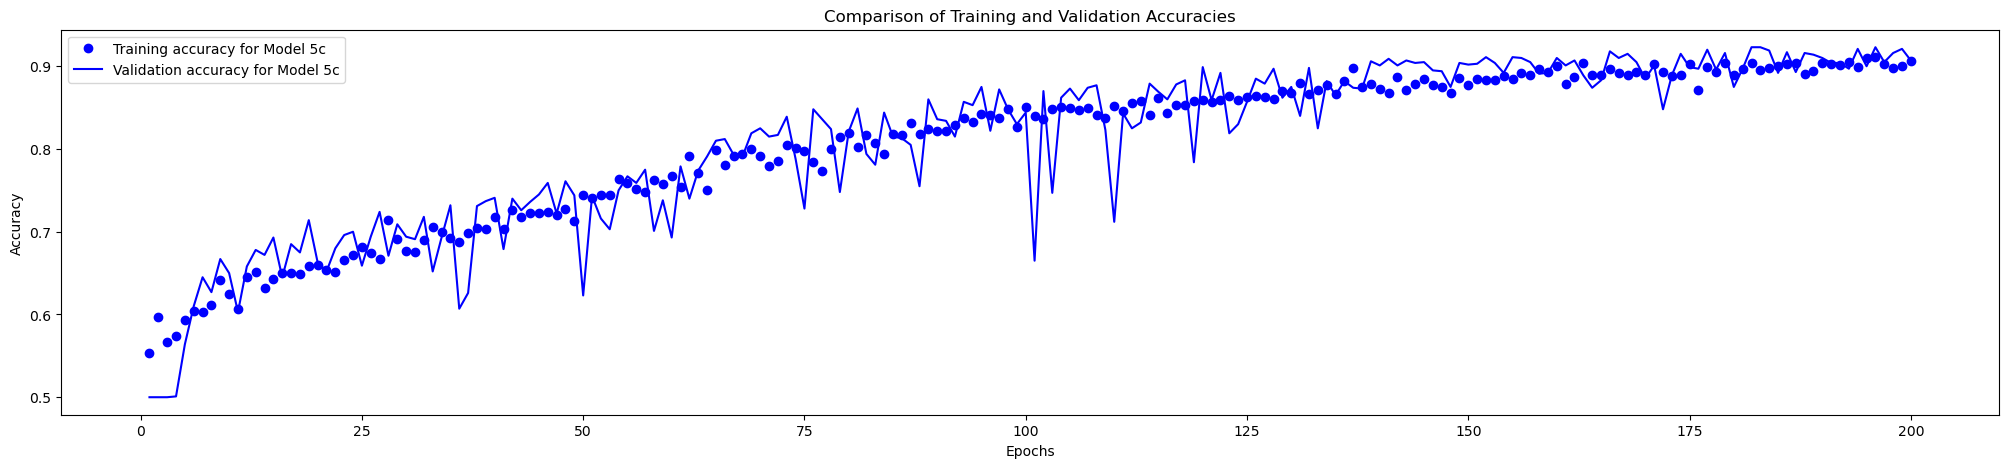

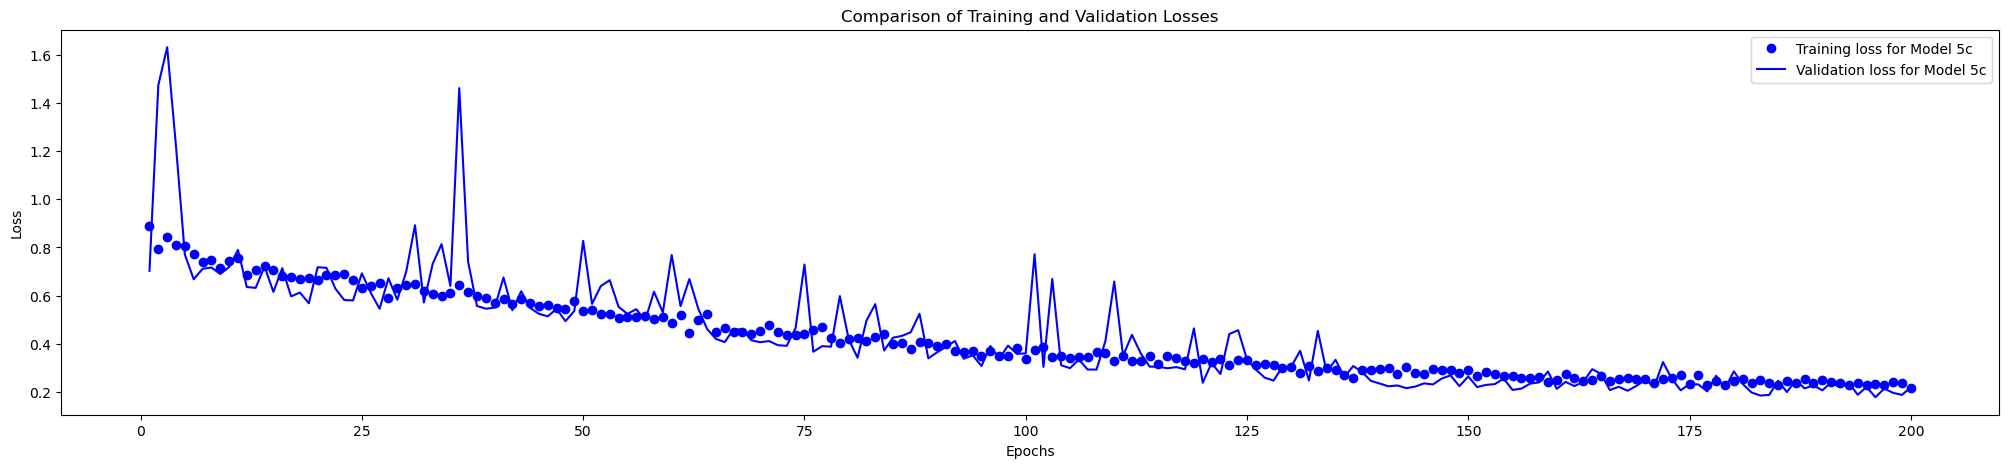

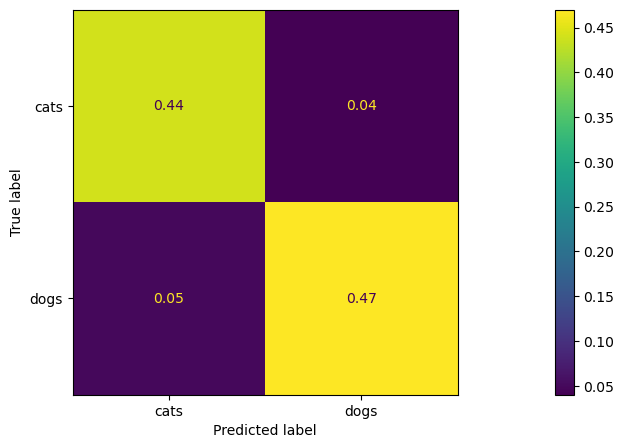

Accuracy: 0.9099999999999999


In [128]:
plot_accuracy_comparison(history5_c, labels=['Model 5c'])
plot_loss_comparison(history5_c, labels=['Model 5c'])
plot_confusion_matrix(model5_c, validation_generator, 100)

In [129]:
model1_c.save(models_dir + 'cats_and_dogs_small_11.keras')
model2_c.save(models_dir + 'cats_and_dogs_small_12.keras')
model3_c.save(models_dir + 'cats_and_dogs_small_13.keras')
model4_c.save(models_dir + 'cats_and_dogs_small_14.keras')
model5_c.save(models_dir + 'cats_and_dogs_small_15.keras')


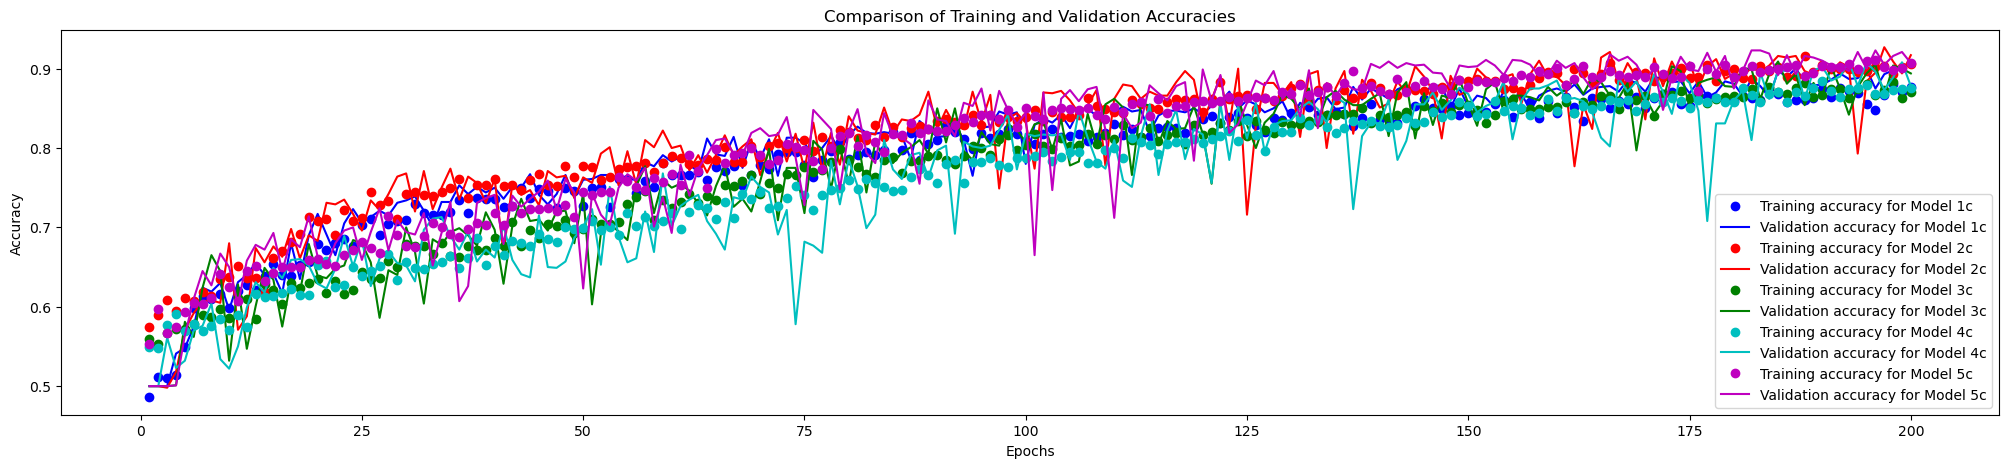

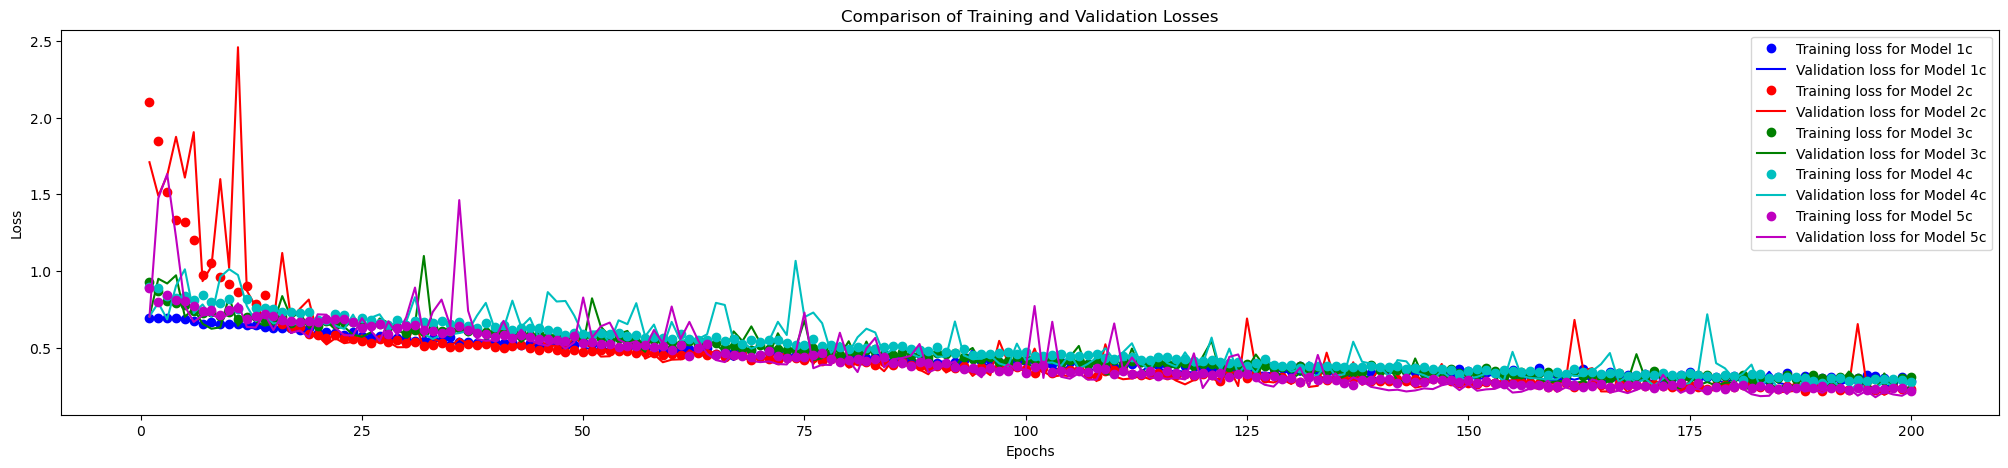

Max accuracy for model 1 is:  0.906000018119812 , achieved in the  199 epoch.
Max accuracy for model 2 is:  0.9269999861717224 , achieved in the  196 epoch.
Max accuracy for model 3 is:  0.9089999794960022 , achieved in the  184 epoch.


In [130]:
plot_accuracy_comparison(history1_c, history2_c, history3_c, history4_c, history5_c, labels=['Model 1c', 'Model 2c', 'Model 3c', 'Model 4c', 'Model 5c'])
plot_loss_comparison(history1_c, history2_c, history3_c, history4_c, history5_c, labels=['Model 1c', 'Model 2c', 'Model 3c', 'Model 4c', 'Model 5c'])
print_val_accuracies(history1_c, history2_c, history3_c)

# Conclusion